In [1]:
#2021/11/04
#dicomデータからCTのtifデータを取り出す

#2021/11/05
#目標 CT2mm:288*288にresizeして取り出す
#     PT2mmCTAC,PT4mmCTAC:288*288 or 144*144の症例をSUV表示で取り出す

In [11]:
#%% いろいろインポート
import PIL
import pathlib
import numpy as np
import pandas as pd
import os
import re
import pydicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clr
import tifffile
import time
import cv2


In [12]:
#関数
#背景が透明なカラーマップを作成
def clearcmap(cmap,txt=1):
    if txt is 1:
        print("="*50)
        print("RUN:def clearcmap")
    cmap_data = cmap(np.arange(cmap.N))
    cmap_data[0, 3] = 0 # 0 のときのα値を0(透明)にする
    customized_cmap =clr.ListedColormap(cmap_data)
    return customized_cmap

In [13]:
#dice係数の計算
#thresh_a,thresh_b:比較する2つのしきい値画像(0から1に正規化)
def Dice_Calculater(thresh_a,thresh_b):
    thresh_a=thresh_a/np.max(thresh_a)
    thresh_b=thresh_b/np.max(thresh_b)

    axb=np.sum(thresh_a*thresh_b)#aかつb
    atb=np.sum(thresh_a)+np.sum(thresh_b)#aまたはb
    
    #dice係数の計算式
    dice_f=2*np.sum(axb/atb)
    
    return dice_f
    
    


In [14]:
#path

dir_path_anno=r"C:\Users\k\Desktop\seki_sotu\anotation"
dir_path_PT=r"C:\Users\k\seki_anno\PT_brain"

['WB126', 'WB127', 'WB128', 'WB132', 'WB138']


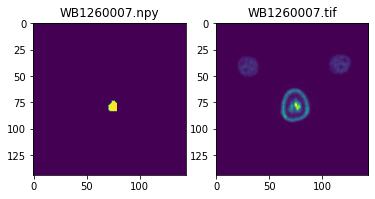

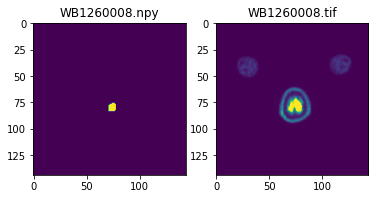

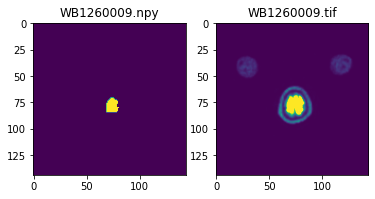

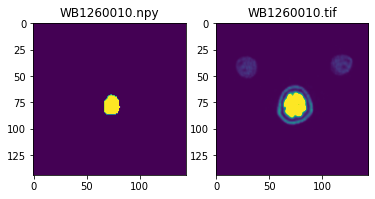

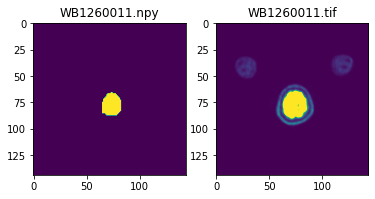

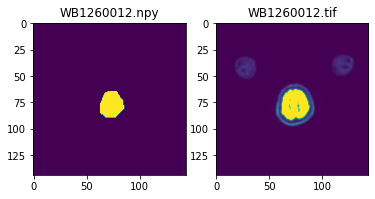

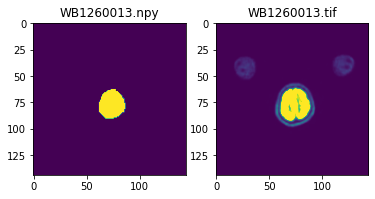

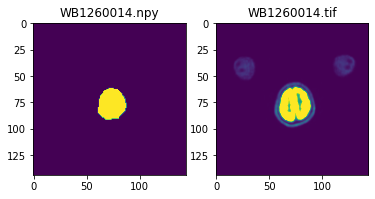

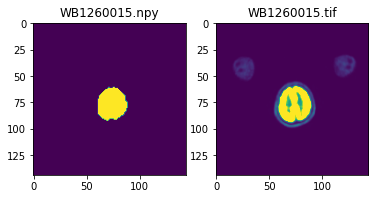

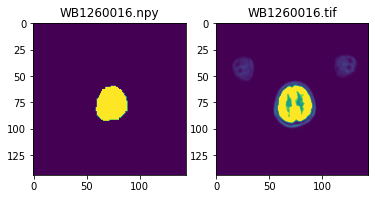

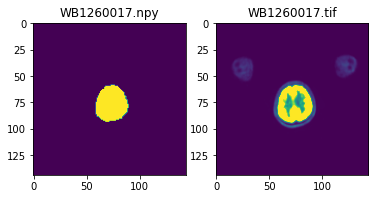

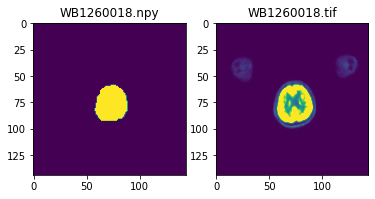

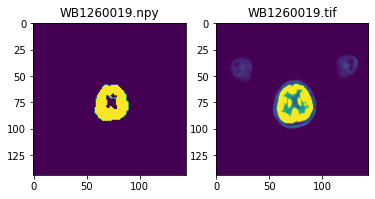

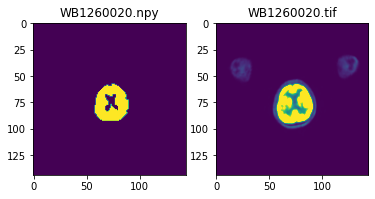

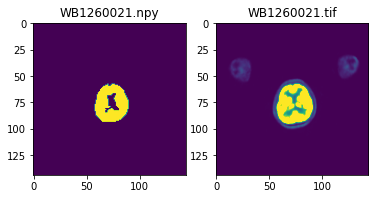

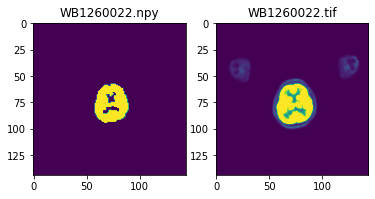

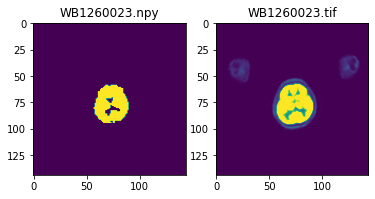

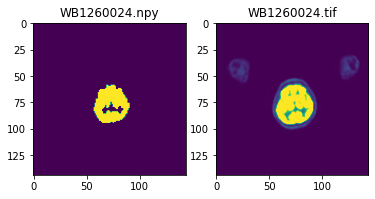

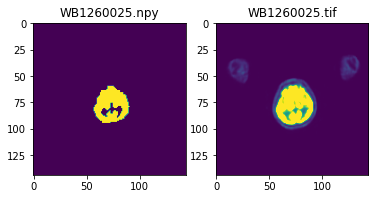

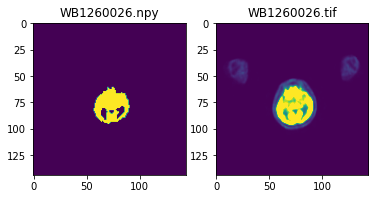

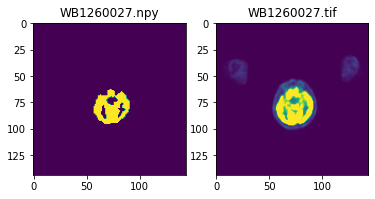

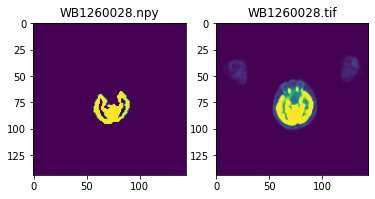

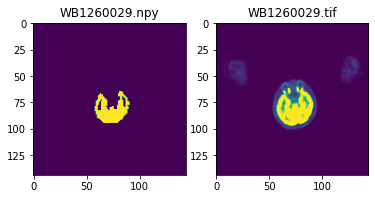

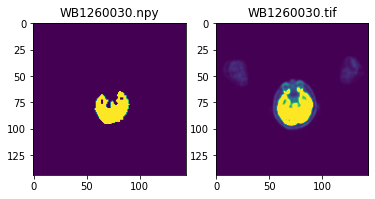

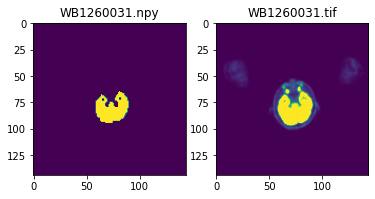

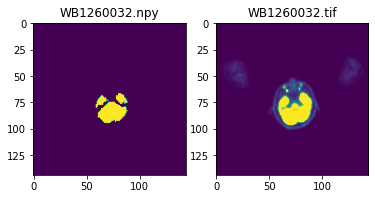

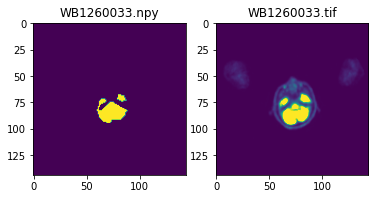

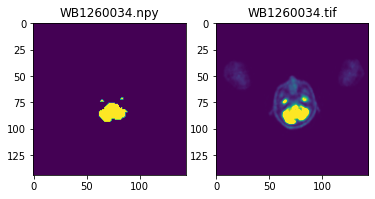

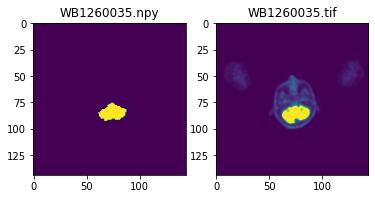

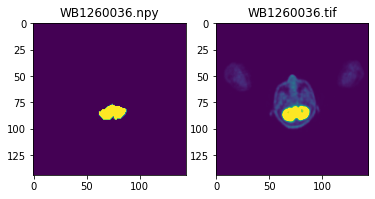

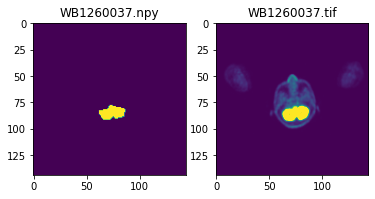

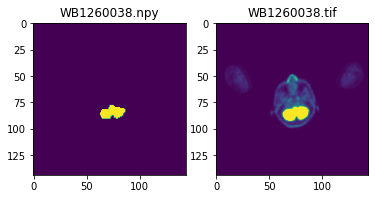

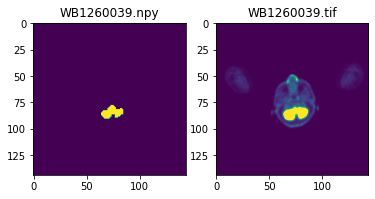

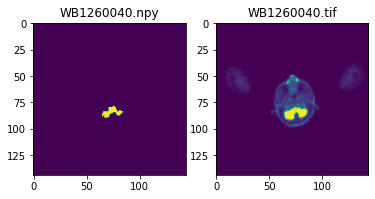

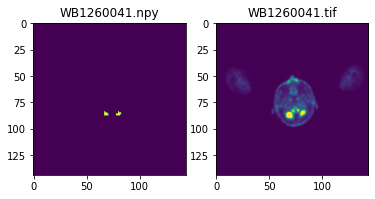

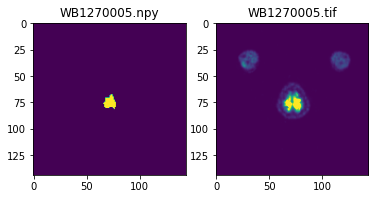

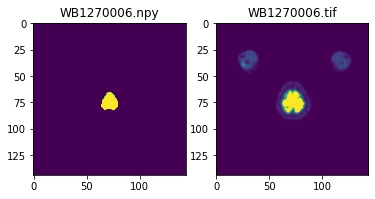

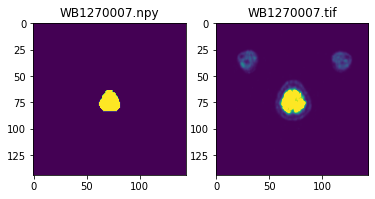

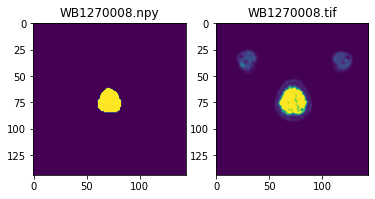

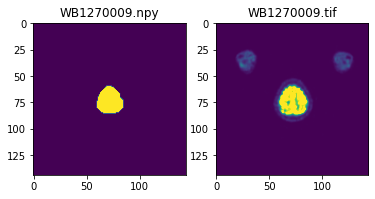

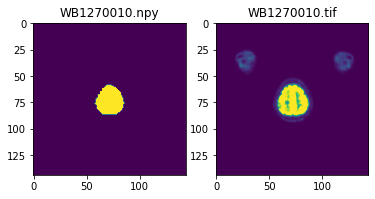

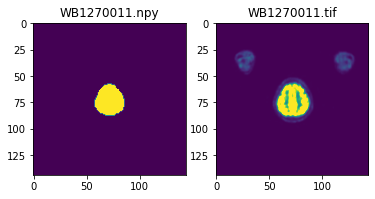

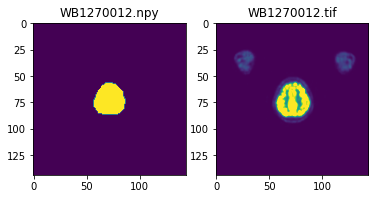

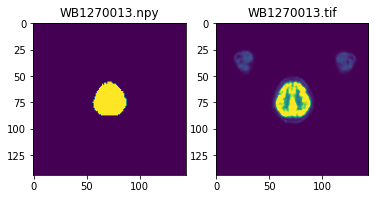

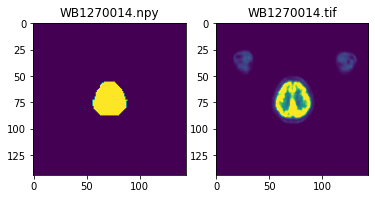

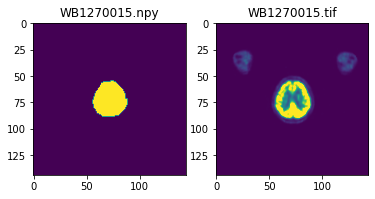

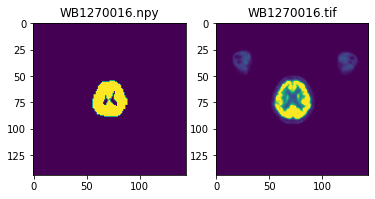

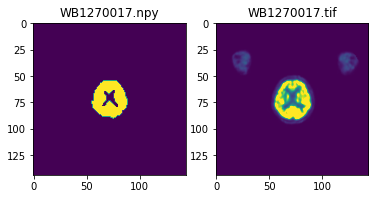

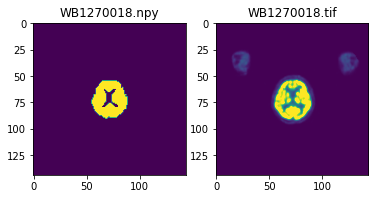

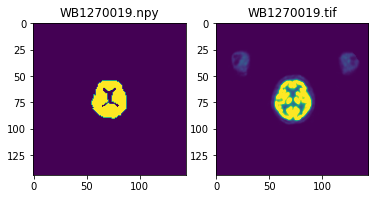

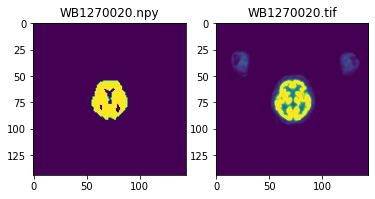

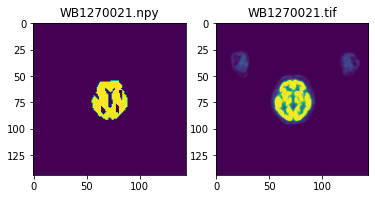

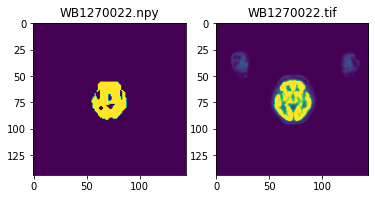

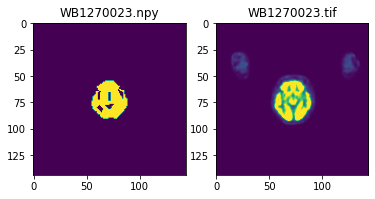

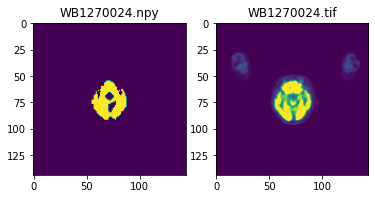

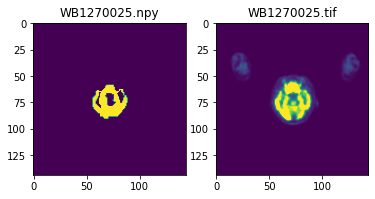

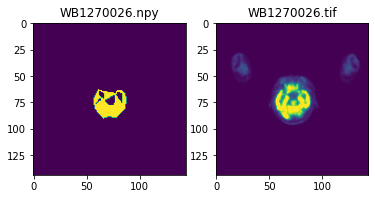

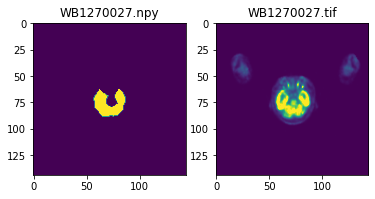

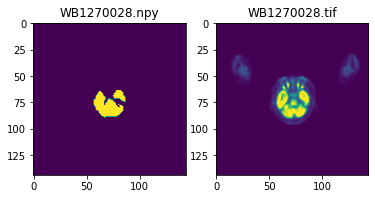

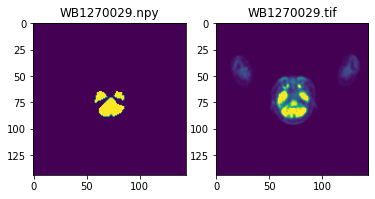

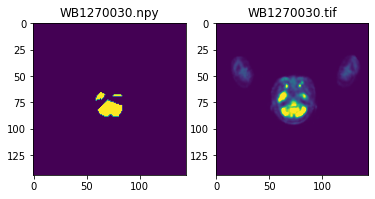

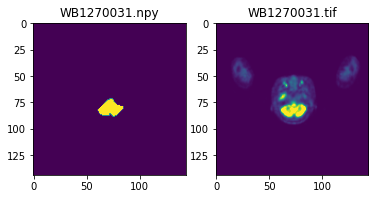

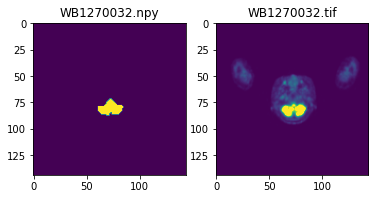

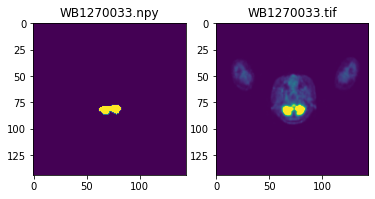

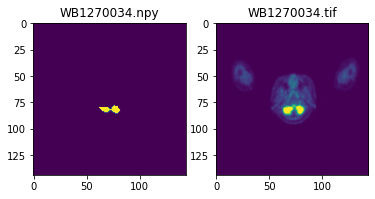

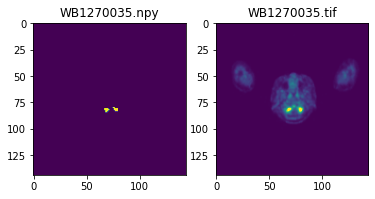

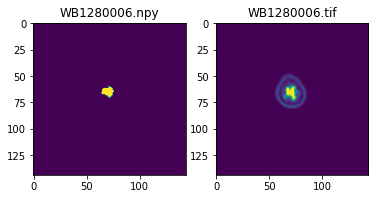

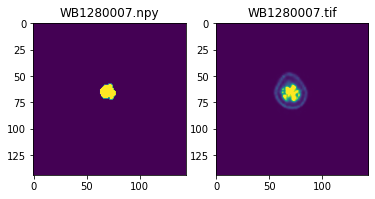

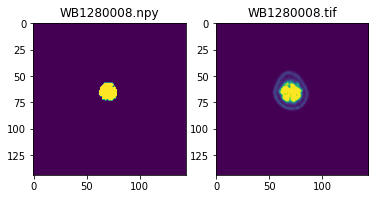

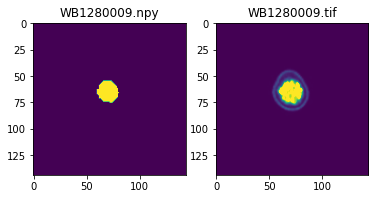

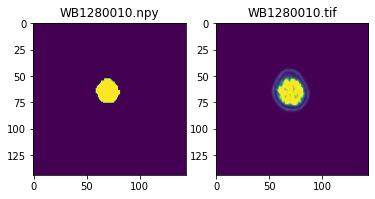

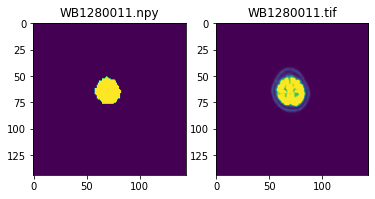

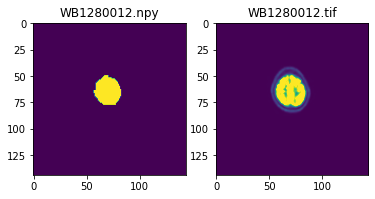

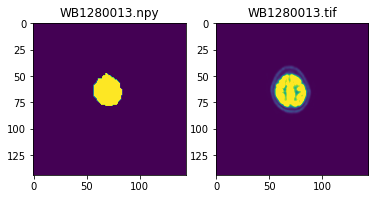

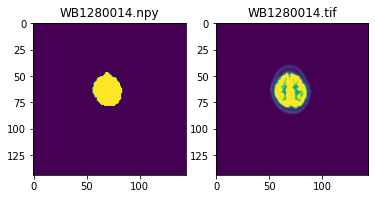

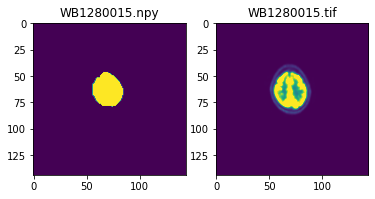

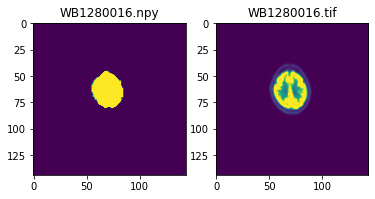

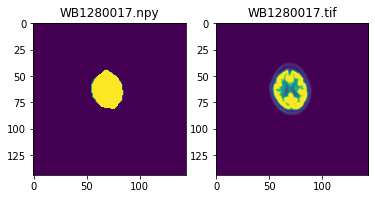

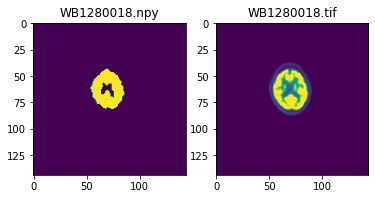

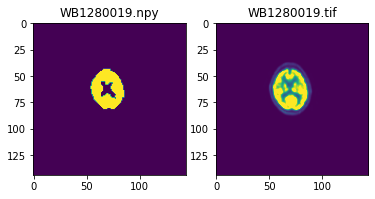

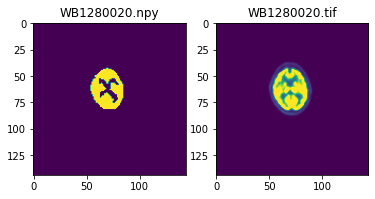

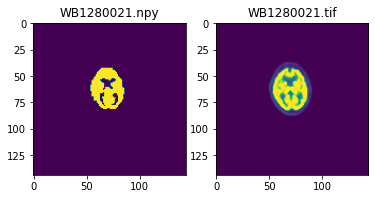

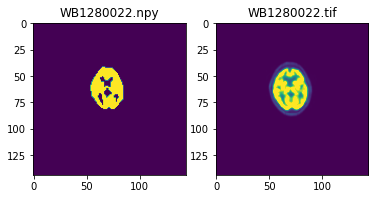

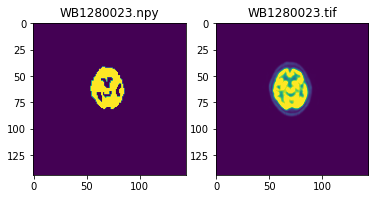

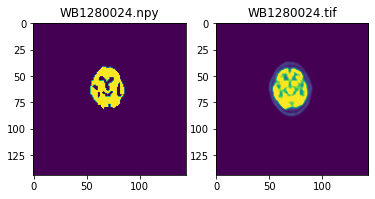

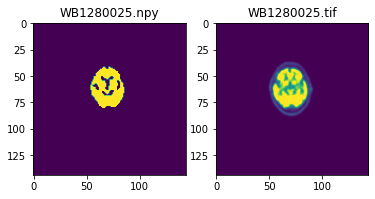

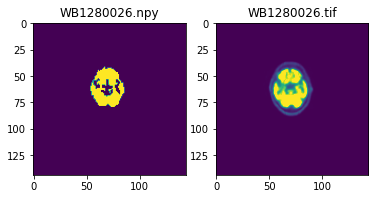

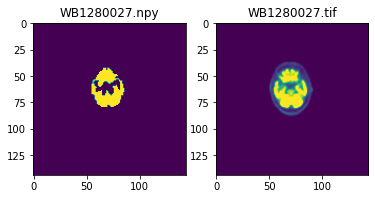

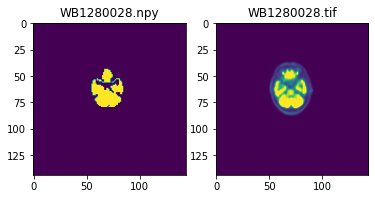

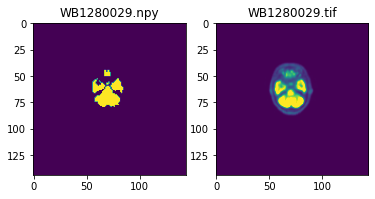

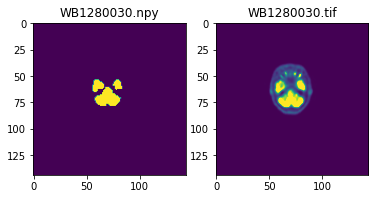

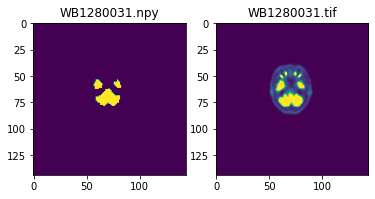

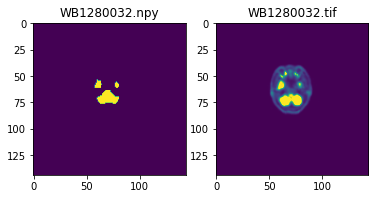

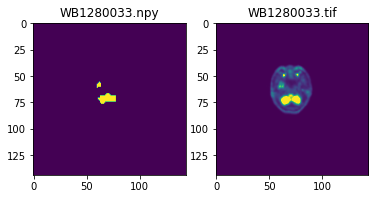

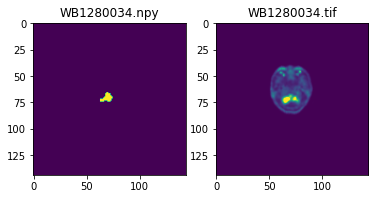

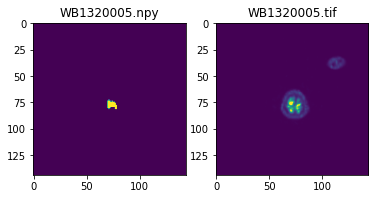

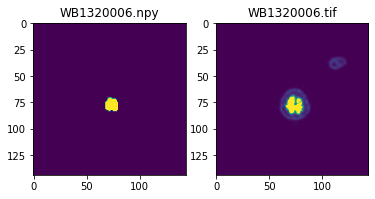

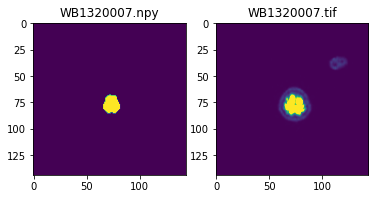

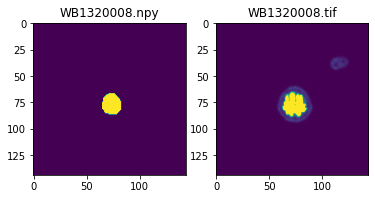

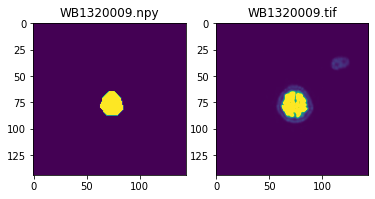

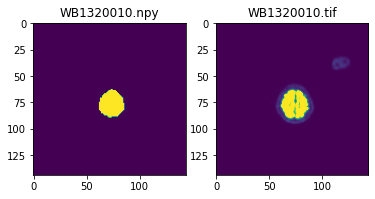

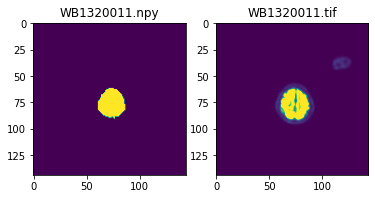

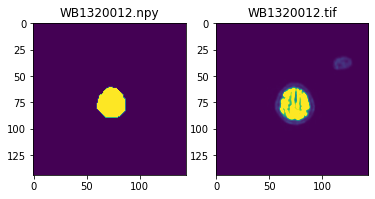

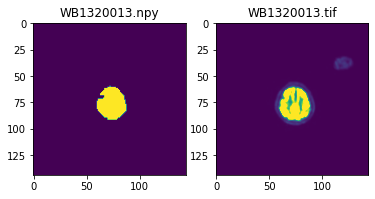

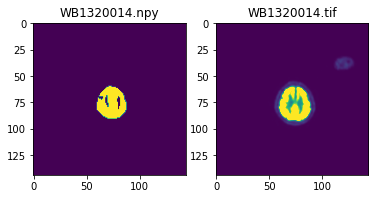

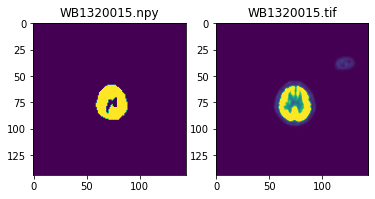

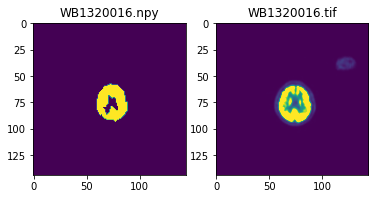

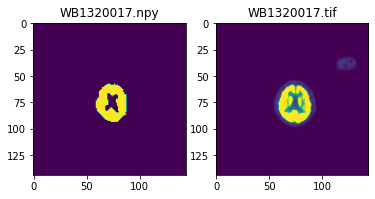

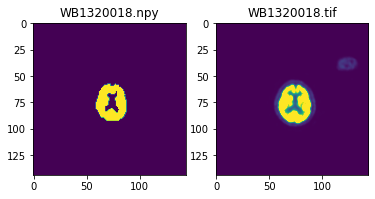

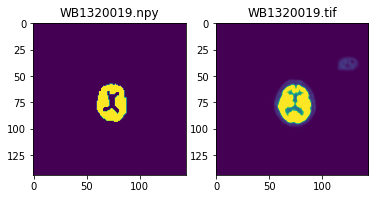

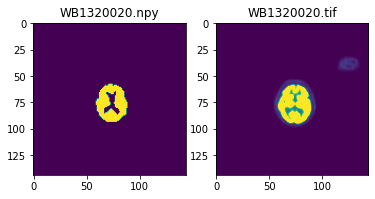

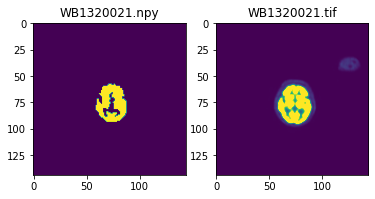

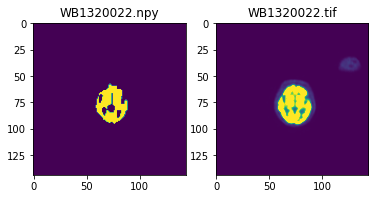

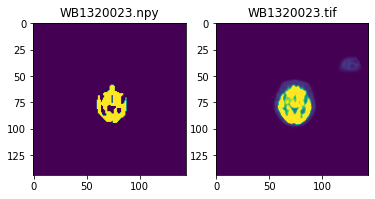

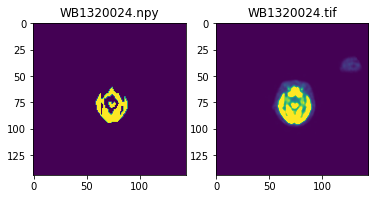

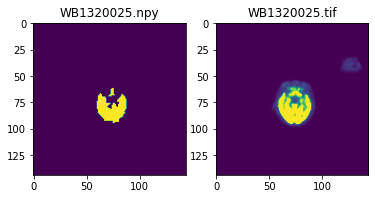

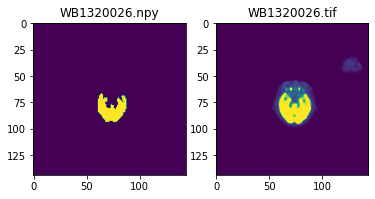

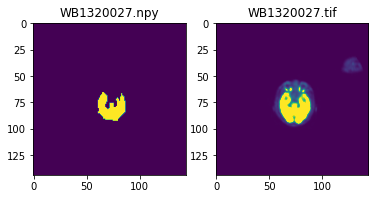

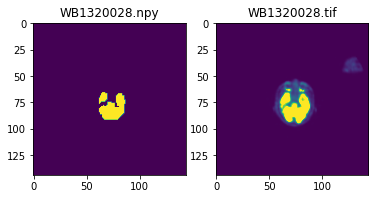

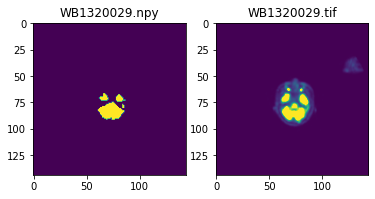

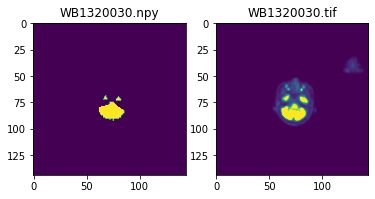

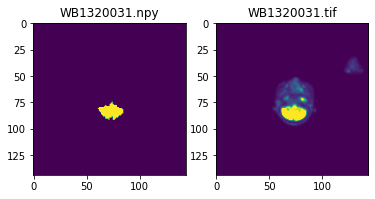

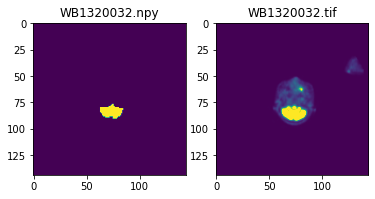

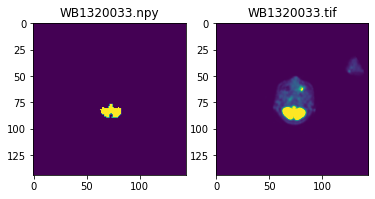

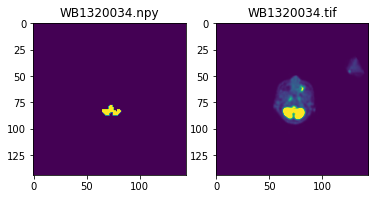

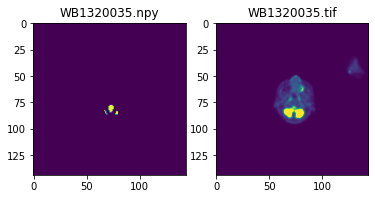

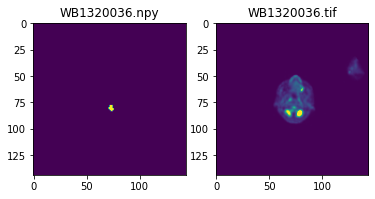

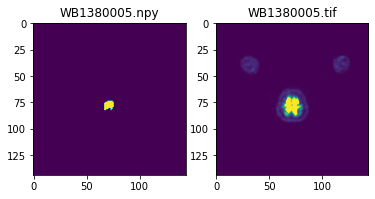

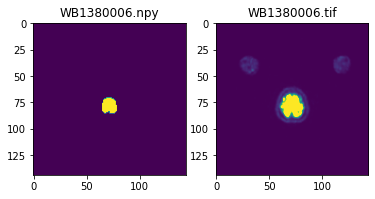

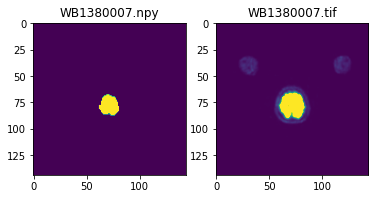

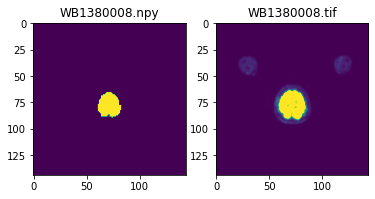

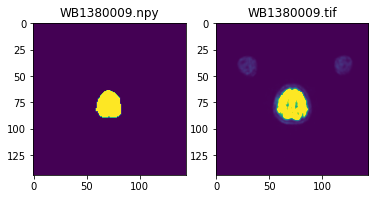

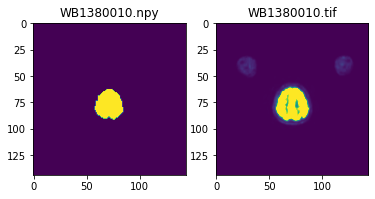

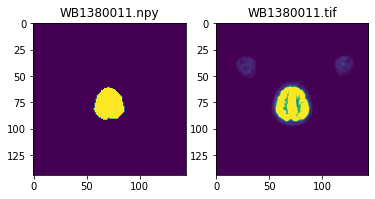

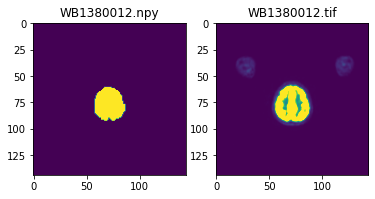

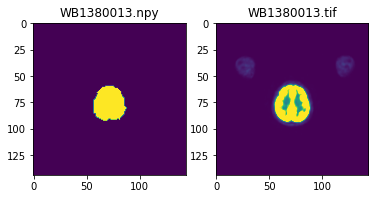

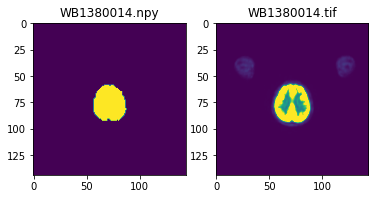

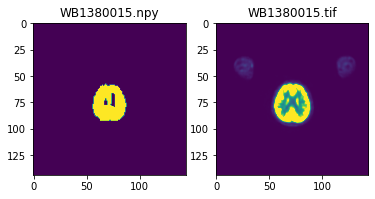

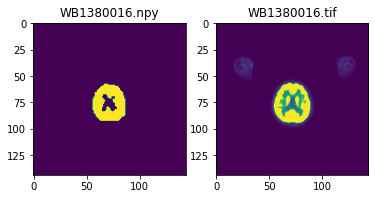

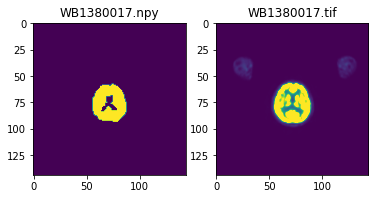

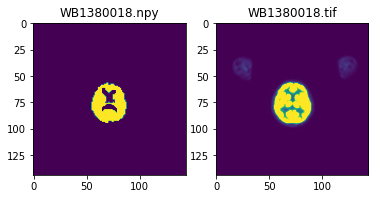

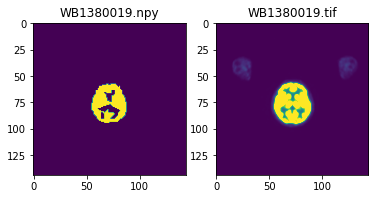

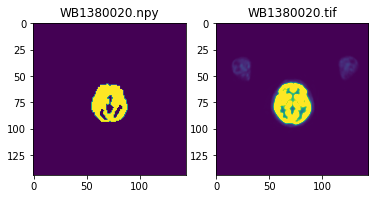

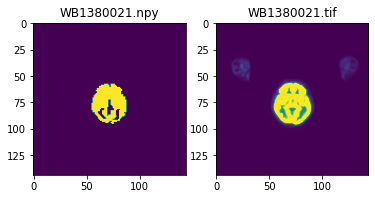

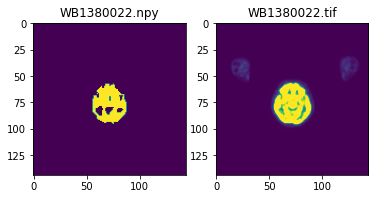

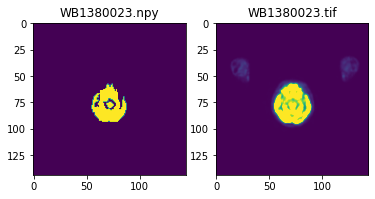

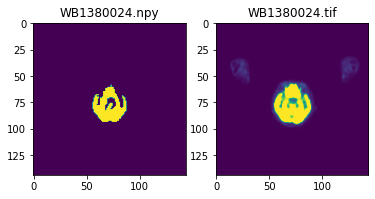

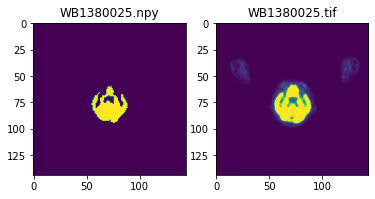

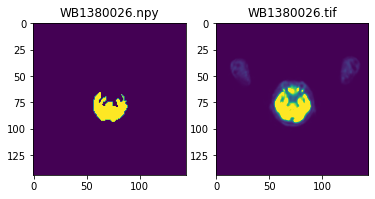

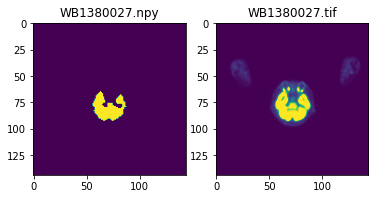

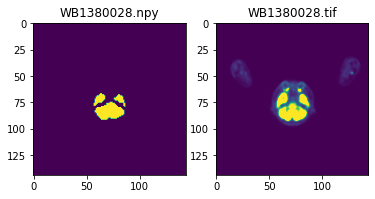

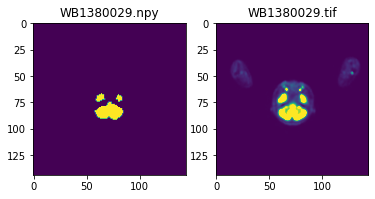

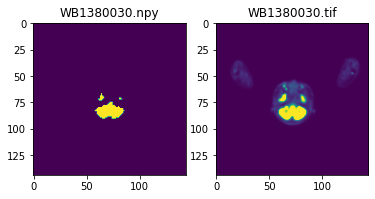

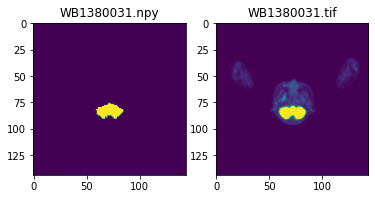

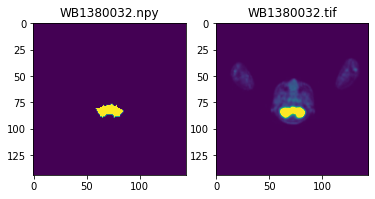

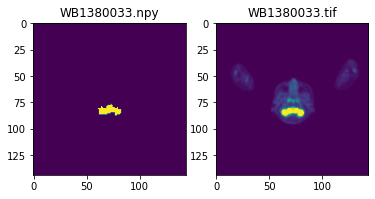

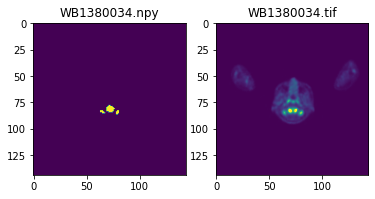

In [15]:
WB_list=os.listdir(dir_path_anno)
print(WB_list)
WB_dic={}
for i,WB in enumerate(WB_list):
    WB_path=os.path.join(dir_path_anno,WB)
    anno_list=os.listdir(WB_path)
    imgs_anno=[]
    imgs_PT=[]
    for j,anno in enumerate(anno_list):
        anno_path=os.path.join(WB_path,anno)
        img_anno=np.load(anno_path)
        imgnumber=anno.split(".")[0]
        p_tif=imgnumber+".tif"
        PT_path=os.path.join(dir_path_PT,WB,p_tif)
        img_PT=tifffile.imread(PT_path)
        
        imgs_anno.append(img_anno)
        imgs_PT.append(img_PT)
        
        fig=plt.figure()
        ax1=fig.add_subplot(121)
        plt.title(WB+anno)
        plt.imshow(img_anno)
        ax2=fig.add_subplot(122)
        plt.title(WB+p_tif)
        plt.imshow(img_PT,vmax=6,vmin=0)
        plt.show()
    
    WB_dic[WB]=[np.array(imgs_anno),np.array(imgs_PT)]

In [16]:
print(WB_dic.keys())

dict_keys(['WB126', 'WB127', 'WB128', 'WB132', 'WB138'])


In [17]:
#手動
def method_th1(imgPT,thSUV):
    ret,imgb=cv2.threshold(imgPT,thSUV,1,cv2.THRESH_BINARY)
    return ret,imgb

In [18]:
#ラプラシアン

#ラプラシアンフィルター
def filter2d(src, kernel):
    m, n = kernel.shape
    d = int((m-1)/2)
    h, w = src.shape[0], src.shape[1]
    dst = np.zeros((h, w))
    for y in range(d, h - d):
        for x in range(d, w - d):
            dst[y][x] = np.sum(src[y-d:y+d+1, x-d:x+d+1]*kernel)
    return dst
kernel = np.array([[1, 1,  1],
                   [1, -8, 1],
                   [1, 1,  1]])

def method_th2_laphis(img):
    dst = filter2d(img, kernel)
    img2 = np.array(dst/np.max(dst)*255,dtype="uint8")
    ret,thresh1 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img255=img/img.max()*255
    ret2,imgb = cv2.threshold(img255,ret,255,cv2.THRESH_BINARY)
    return ret2,imgb

def method_OTSU(imgPT):
    img2 = np.array(imgPT/np.max(imgPT)*255,dtype="uint8")
    ret,thresh1 = cv2.threshold(img2,0,255,cv2.THRESH_OTSU)

    return ret2,thresh1

In [19]:
#手動+ラプラシアン

#ラプラシアンフィルター
def filter2d(src, kernel):
    m, n = kernel.shape
    d = int((m-1)/2)
    h, w = src.shape[0], src.shape[1]
    dst = np.zeros((h, w))
    for y in range(d, h - d):
        for x in range(d, w - d):
            dst[y][x] = np.sum(src[y-d:y+d+1, x-d:x+d+1]*kernel)
    return dst
kernel = np.array([[1, 1,  1],
                   [1, -8, 1],
                   [1, 1,  1]])

def method_th3_laphis_2(img,ret1):
    dst = filter2d(img, kernel)
    img2 = np.array(dst/np.max(dst)*255,dtype="uint8")
    ret2,thresh2 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img255=img/img.max()*255
    #print(ret1/img.max()*255,ret2)
    ret12=(ret1/img.max()*255+ret2)/2
    ret3,imgb = cv2.threshold(img255,ret12,255,cv2.THRESH_BINARY)
    return ret12,imgb


In [21]:
#ダブルラプラシアン
def method4_double_laphis(img):
        dst = filter2d(img, kernel)
        img2 = np.array(dst/np.max(dst)*255,dtype="uint8")
        ret,thresh1 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        img255=img/img.max()*255
        ret2,thresh2 = cv2.threshold(img255,ret,255,cv2.THRESH_BINARY)
        img3=(thresh2//255-1)*-1
        nikai=img3*img255
        dst2 = filter2d(nikai, kernel)
        img4 = np.array(dst2/np.max(dst2)*255,dtype="uint8")
        ret3,thresh3 = cv2.threshold(img4,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        img255_2 = nikai/nikai.max()*255
        ret4,thresh4 = cv2.threshold(img255_2,ret3,255,cv2.THRESH_BINARY)
        print("ret:",ret/255*img.max(),ret3/255*nikai.max())
#         retSUV=np.array([ret/255*img.max(),ret3/255*nikai.max()])
        return ret3/255*nikai.max(),thresh2+thresh4

In [42]:
# def method4_double_laphis(img):
#         ret_list=[2.27,1.73,2.19,2.55,2.2]
#         dst = filter2d(img, kernel)
#         img2 = np.array(dst/np.max(dst)*255,dtype="uint8")
#         ret,thresh1 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#         img255=img/img.max()*255
#         ret2,thresh2 = cv2.threshold(img255,ret,255,cv2.THRESH_BINARY)
#         img3=(thresh2//255-1)*-1
#         nikai=img3*img255
#         dst2 = filter2d(nikai, kernel)
#         img4 = np.array(dst2/np.max(dst2)*255,dtype="uint8")
#         ret3,thresh3 = cv2.threshold(img4,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#         img255_2 = nikai/nikai.max()*255
#         ret4,thresh4 = cv2.threshold(img255_2,ret3,255,cv2.THRESH_BINARY)
#         for kaisu in range(len(ret_list)):
#             if ret_rist[kaisu]<ret:
#                 ret2,imgd=method4_double_laphis(imgPT)
#             else:
#                 ret2,imgd=method_th2_laphis(imgPT)
#         print("ret:",ret/255*img.max(),ret3/255*nikai.max())
# #         retSUV=np.array([ret/255*img.max(),ret3/255*nikai.max()])
#         return ret3/255*nikai.max(),thresh2+thresh4

In [68]:
ret1/255*imgPT.max()

4.171418133903952

In [69]:
ret2/255*imgPT.max()

4.171418133903952

In [79]:
ret_kijun/imgPT.max()*255

63.28782958828617

ret: 3.2440502391142 54.38474629720052
1.0
255.0


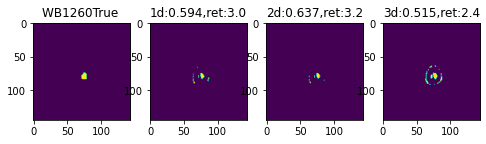

ret: 4.998194167193245 51.44212072035846
1.0
255.0


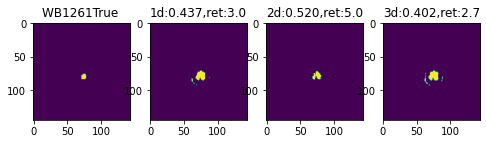

ret: 5.268510425792021 52.71016737994025
1.0
255.0


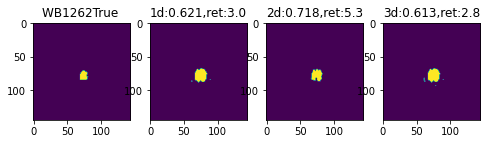

ret: 5.3612548828125 49.62614770029106
1.0
255.0


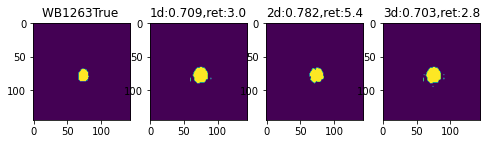

ret: 5.284846062753715 49.56297287286497
1.0
255.0


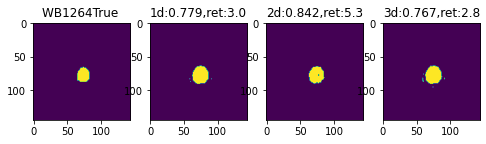

ret: 5.04130906123741 46.80025562959559
1.0
255.0


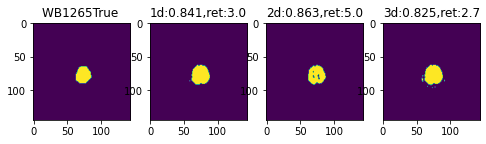

ret: 5.188868967692057 46.75600774428423
1.0
255.0


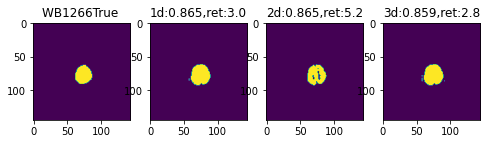

ret: 5.312291538014131 45.088350782207414
1.0
255.0


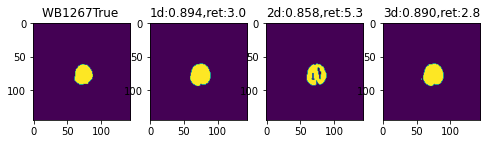

ret: 5.164481667911305 46.19733267391429
1.0
255.0


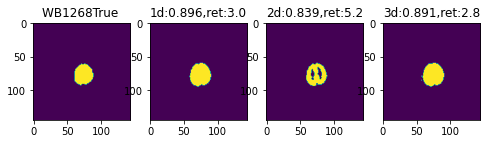

ret: 5.407004300285788 46.88448576085708
1.0
255.0


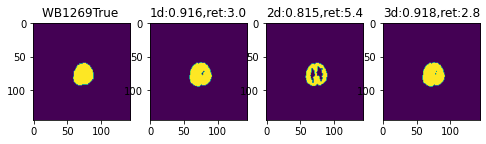

ret: 5.776732500861673 49.05581712909773
1.0
255.0


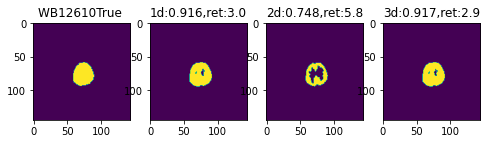

ret: 5.454066298989688 48.62056328268612
1.0
255.0


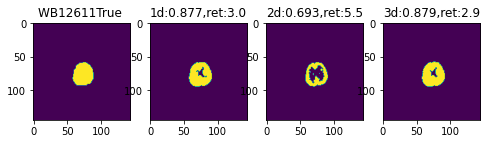

ret: 5.869834466074027 47.856438131893384
1.0
255.0


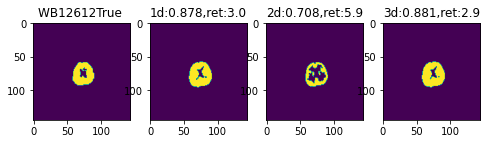

ret: 5.467068399167529 46.12832740334903
1.0
255.0


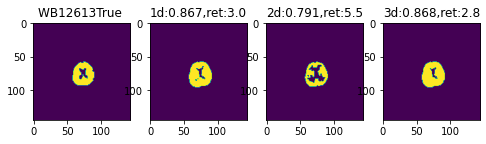

ret: 5.846936887853286 45.13751513911228
1.0
255.0


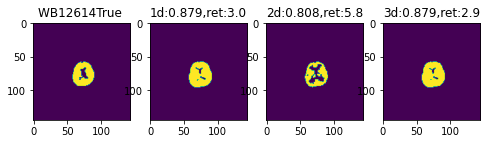

ret: 6.192684368058747 44.422316128599874
1.0
255.0


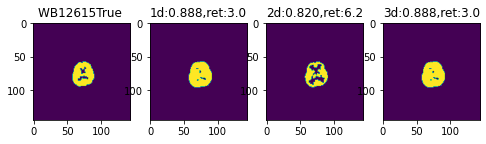

ret: 6.0826052160824045 44.28266039081649
1.0
255.0


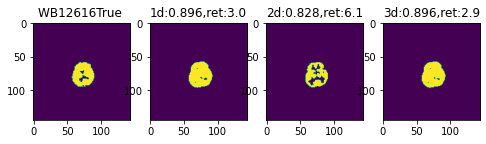

ret: 5.994049790326287 44.81642928777957
1.0
255.0


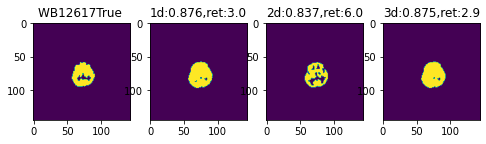

ret: 5.519977442423503 46.55073385799632
1.0
255.0


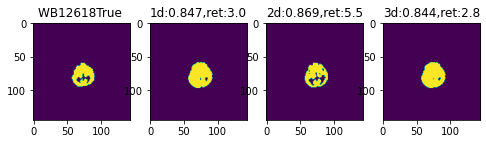

ret: 5.9721767911724015 46.95486510033701
1.0
255.0


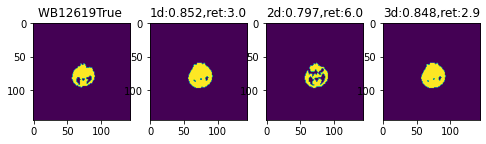

ret: 6.365160362393248 48.3042054419424
1.0
255.0


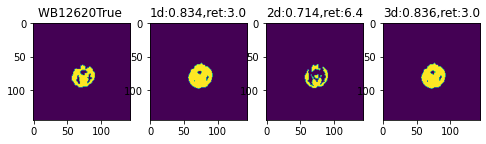

ret: 6.3724873150096215 47.777824850643384
1.0
255.0


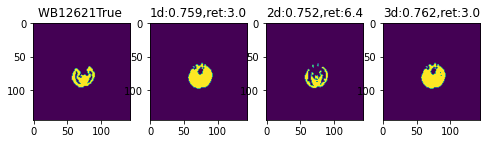

ret: 5.904966376809512 47.282202627144606
1.0
255.0


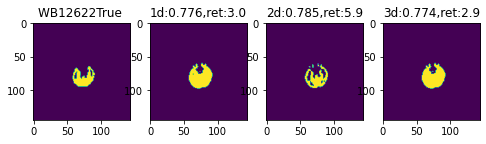

ret: 6.203711244171741 49.13830701042624
1.0
255.0


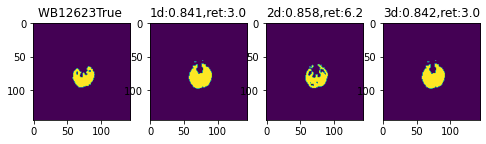

ret: 6.405492906009449 50.04379107905369
1.0
255.0


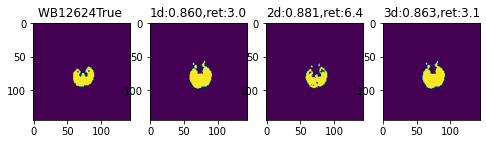

ret: 6.740657757777793 50.633411332672715
1.0
255.0


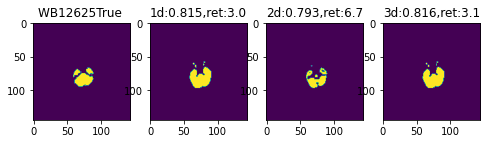

ret: 6.25715165979722 53.14987487792969
1.0
255.0


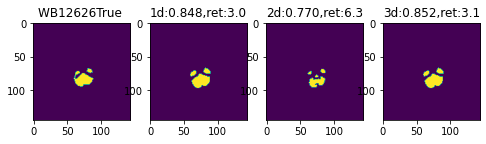

ret: 6.685447064568015 54.91842783011642
1.0
255.0


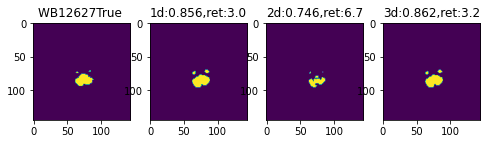

ret: 5.356657046897738 53.59303436279297
1.0
255.0


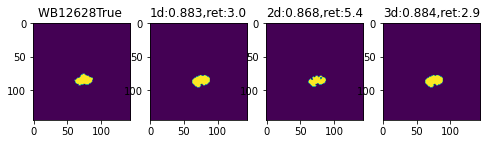

ret: 5.359185746136833 53.42356357948453
1.0
255.0


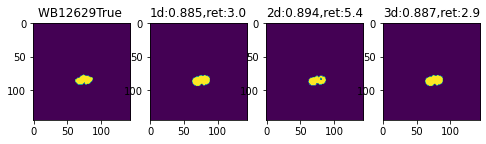

ret: 5.184208454805262 54.68427949793198
1.0
255.0


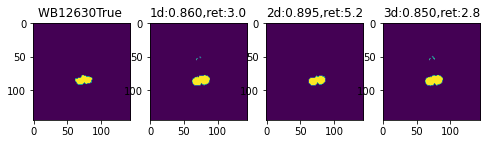

ret: 5.0011172238518204 52.97830188227635
1.0
255.0


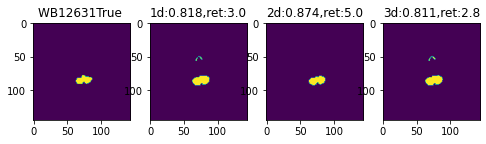

ret: 5.1808124617034315 54.702103917738974
1.0
255.0


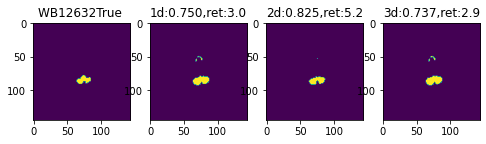

ret: 5.468842203476849 55.27661626479205
1.0
255.0


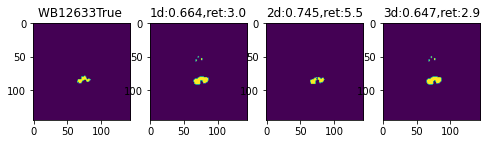

ret: 4.37270756889792 55.35047242407705
1.0
255.0


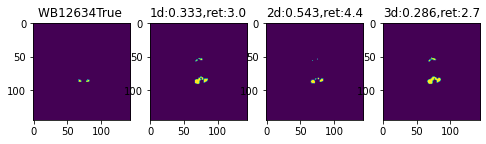

ret: 4.685652340159697 56.251716164981616
1.0
255.0


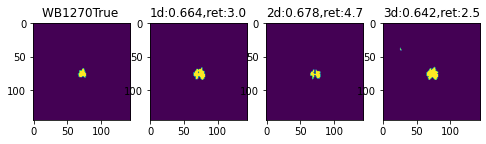

ret: 4.620521119061639 53.86348867977367
1.0
255.0


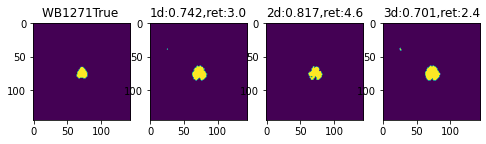

ret: 4.7153112299302045 53.65996345071231
1.0
255.0


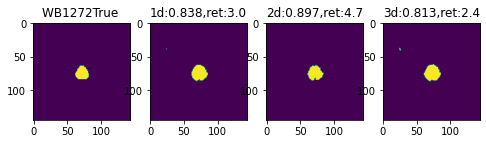

ret: 4.447104341843549 53.578504435221355
1.0
255.0


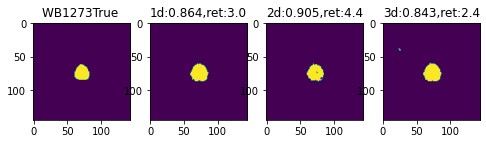

ret: 4.5407451629638675 52.50886601466759
1.0
255.0


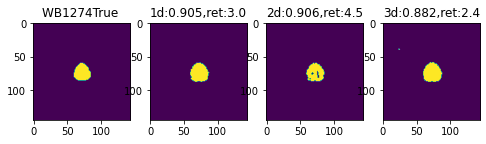

ret: 4.506273587544759 51.531845182531015
1.0
255.0


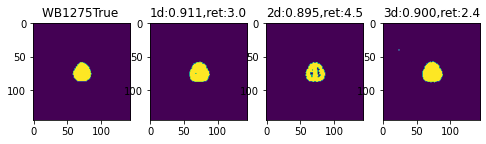

ret: 4.243918549780752 48.542374375287224
1.0
255.0


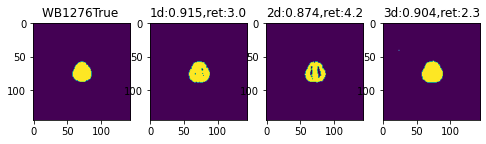

ret: 4.27206594803754 48.57881523581112
1.0
255.0


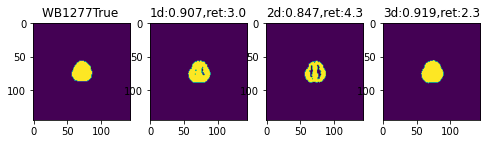

ret: 4.694948906991996 48.2631898169424
1.0
255.0


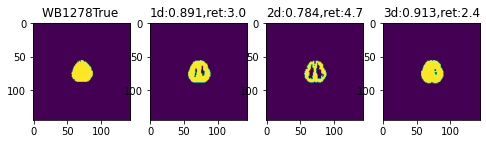

ret: 4.936978598201976 48.29752508425245
1.0
255.0


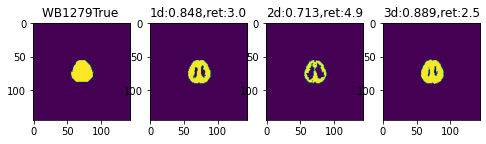

ret: 4.698756722842946 48.12646436504289
1.0
255.0


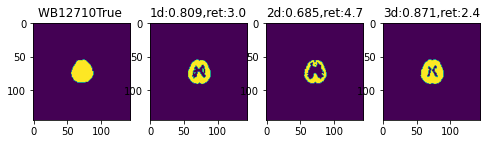

ret: 4.028009740044089 49.134797488941864
1.0
255.0


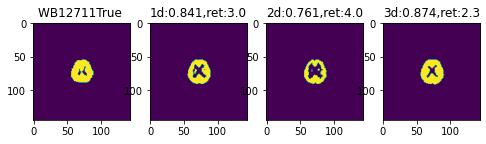

ret: 3.945358085632324 47.74705978094363
1.0
255.0


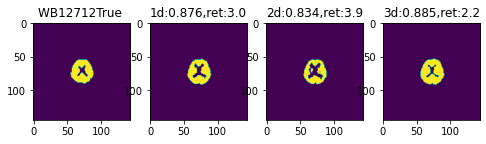

ret: 4.93426939646403 46.105531281115965
1.0
255.0


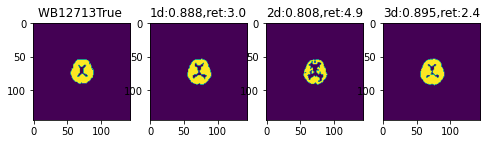

ret: 5.067555917478075 46.4880791757621
1.0
255.0


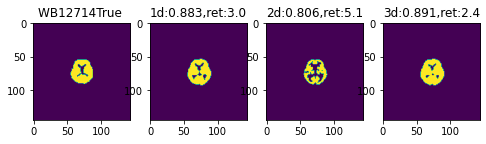

ret: 4.521715680290671 46.13848975686466
1.0
255.0


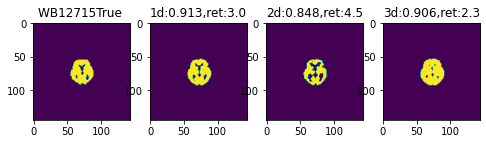

ret: 4.711352404426126 45.247286867627906
1.0
255.0


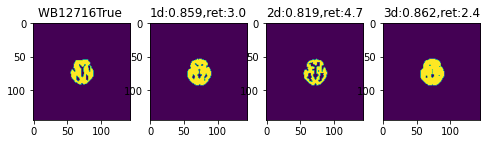

ret: 5.017955185385311 45.65977875952627
1.0
255.0


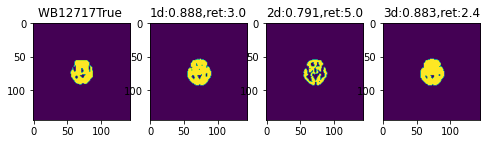

ret: 4.683275656606637 45.68639334884344
1.0
255.0


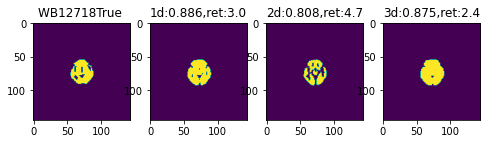

ret: 5.004909706115723 48.23538513183594
1.0
255.0


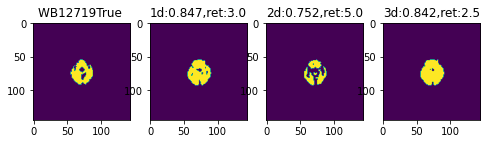

ret: 4.2700141831940295 48.721695664349724
1.0
255.0


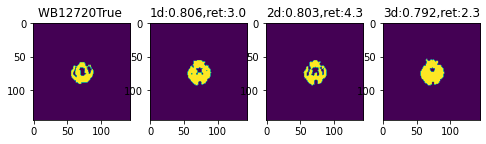

ret: 4.271657427619486 51.37394445082721
1.0
255.0


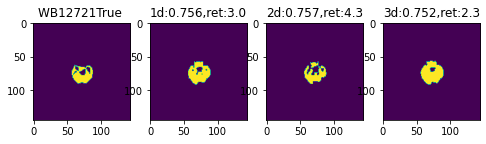

ret: 4.017064262838925 50.899379057042744
1.0
255.0


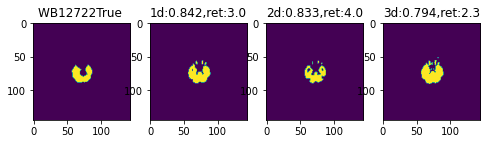

ret: 3.9519800298354206 51.806510775697
1.0
255.0


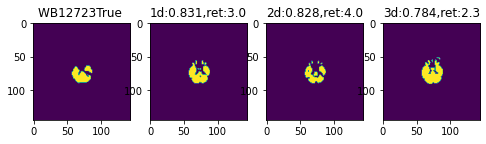

ret: 4.3352402930166205 53.12793300853056
1.0
255.0


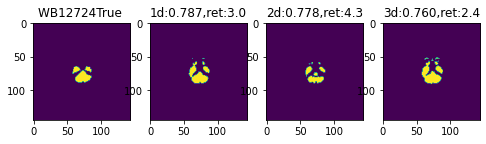

ret: 4.010606743307674 54.224952697753906
1.0
255.0


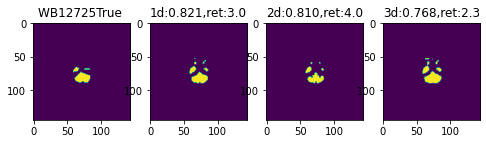

ret: 3.9684199763279335 56.17652025409774
1.0
255.0


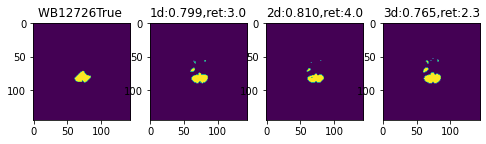

ret: 4.117472734638289 57.15991755466835
1.0
255.0


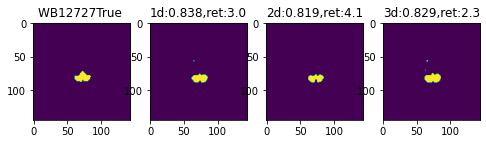

ret: 4.087083752950033 54.82054799397787
1.0
255.0


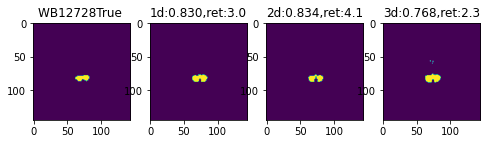

ret: 4.396344502766927 56.731283389820774
1.0
255.0


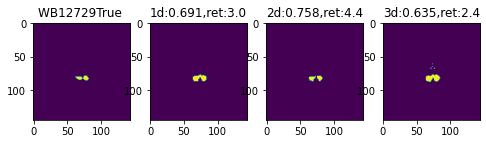

ret: 3.327900303111357 54.70070546468099
1.0
255.0


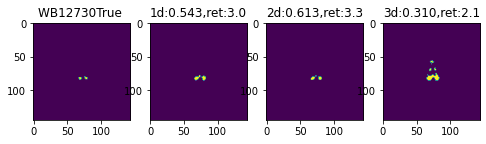

ret: 3.9246912039962467 48.00683629653033
1.0
255.0


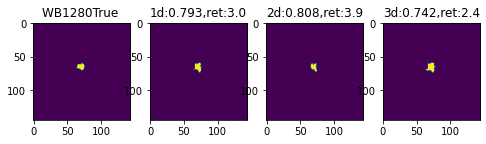

ret: 3.836432423311121 47.83776496438419
1.0
255.0


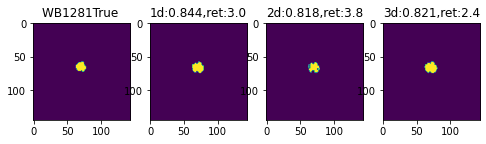

ret: 3.742675242704504 48.157838709214154
1.0
255.0


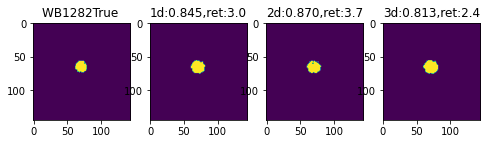

ret: 3.8937433579388787 41.603805482153795
1.0
255.0


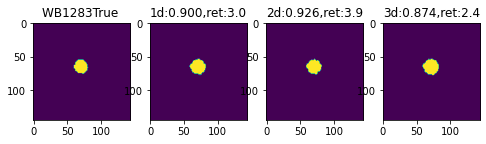

ret: 3.6879748924105775 40.61631954417509
1.0
255.0


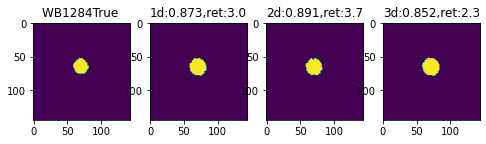

ret: 3.3406533072976505 36.170540603936885
1.0
255.0


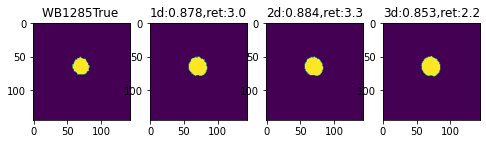

ret: 3.5076911028693702 36.40553193933823
1.0
255.0


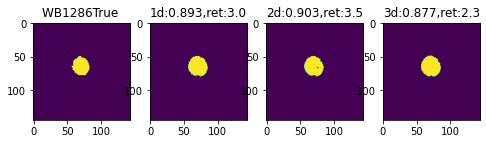

ret: 3.349188651290594 36.18085452809053
1.0
255.0


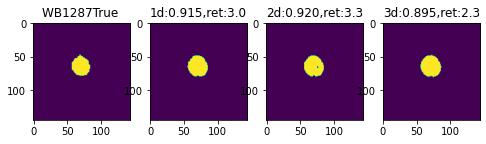

ret: 3.5556585274490655 36.28754631491269
1.0
255.0


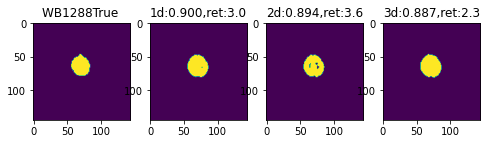

ret: 3.7791376300886568 37.07998836741728
1.0
255.0


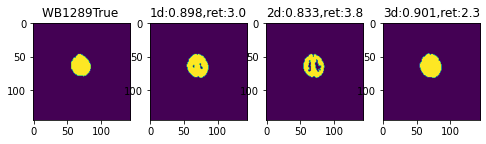

ret: 3.6109400431315106 35.71892568550858
1.0
255.0


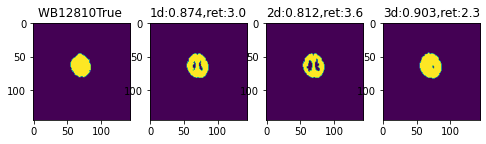

ret: 3.536444727579753 37.198035625382964
1.0
255.0


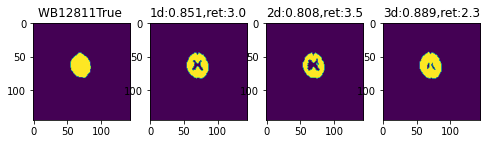

ret: 3.4602268144196153 33.89416240617341
1.0
255.0


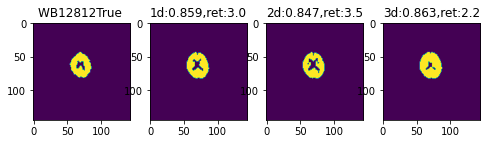

ret: 3.436298071169386 34.53328067555147
1.0
255.0


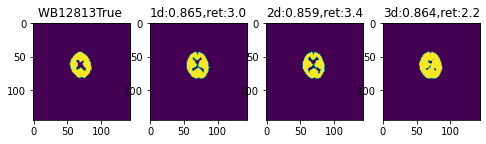

ret: 3.9552463419297164 33.15894129136029
1.0
255.0


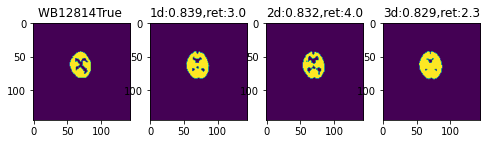

ret: 3.843599450354483 33.065280061609606
1.0
255.0


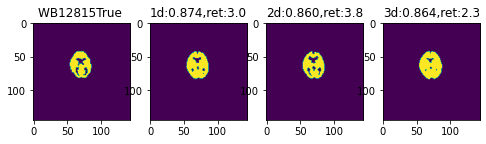

ret: 3.8205679014617324 33.17597009995404
1.0
255.0


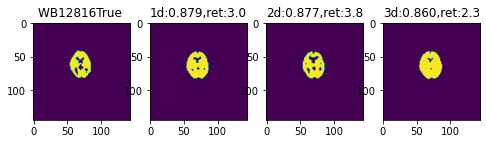

ret: 3.815450107350069 33.09378309062883
1.0
255.0


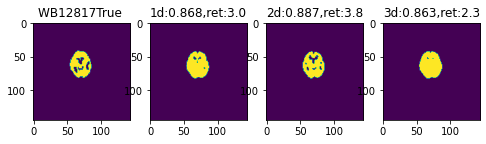

ret: 3.704416222665824 34.19675520354626
1.0
255.0


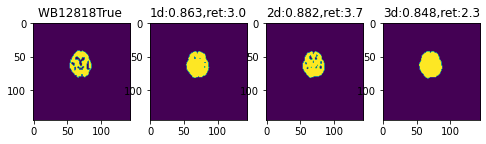

ret: 3.4152452207079125 36.10211857814415
1.0
255.0


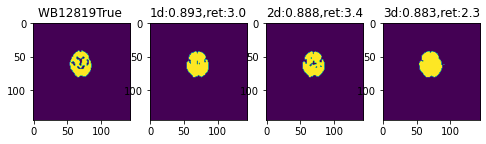

ret: 3.5136173659679937 35.330364750880825
1.0
255.0


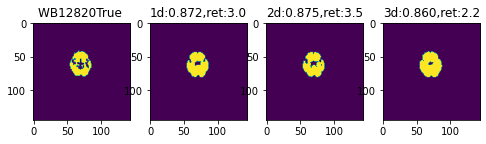

ret: 3.478707238739612 35.699333639705884
1.0
255.0


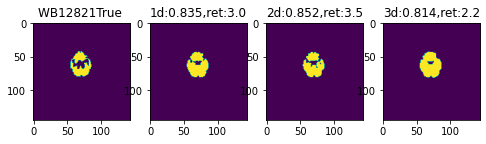

ret: 3.606432372448491 36.77868293313419
1.0
255.0


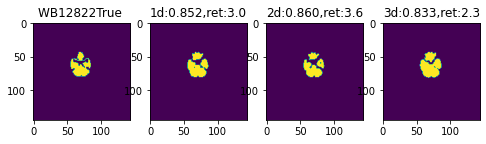

ret: 3.570474063648897 39.49476399141199
1.0
255.0


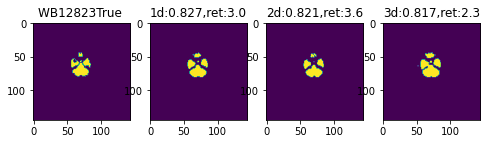

ret: 3.679937276653215 41.140414129518994
1.0
255.0


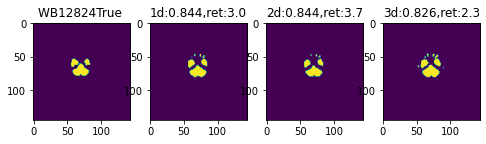

ret: 4.165504059137082 41.98333692363664
1.0
255.0


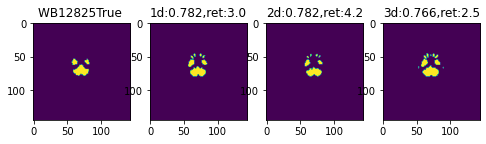

ret: 3.841123562233121 42.68977876551011
1.0
255.0


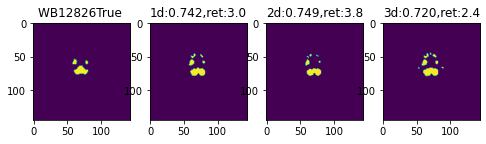

ret: 4.13936570111443 48.15307940314798
1.0
255.0


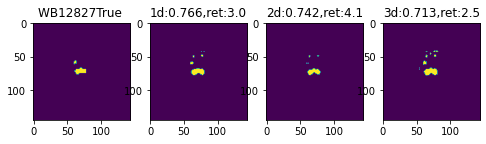

ret: 3.4572786892161647 49.152351977778416
1.0
255.0


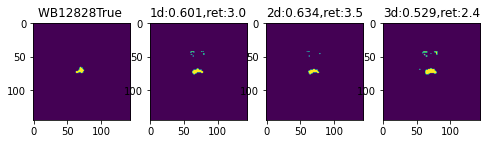

ret: 3.6763454549452836 55.53025907628677
1.0
255.0


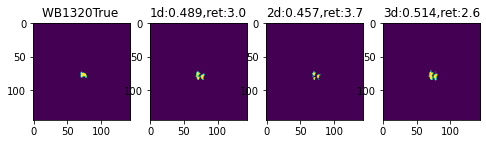

ret: 5.384268801820045 53.61711677102481
1.0
255.0


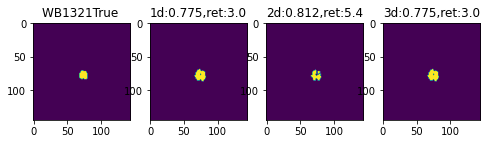

ret: 5.792314260146197 51.85253822476256
1.0
255.0


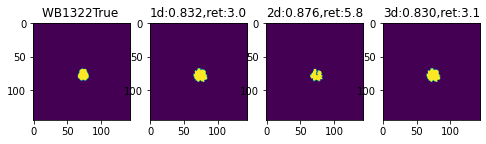

ret: 5.106821209776635 49.87359044692096
1.0
255.0


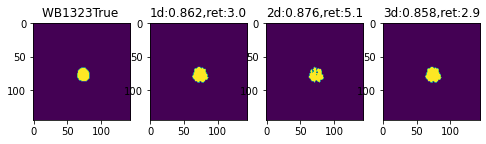

ret: 5.376617311963848 48.53321605009191
1.0
255.0


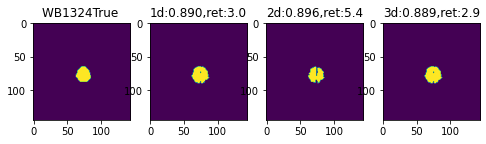

ret: 5.3325486201866 45.623188183354394
1.0
255.0


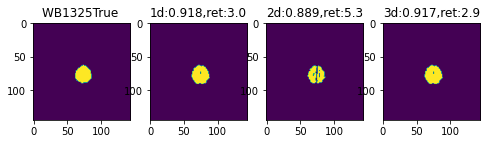

ret: 5.128561760397519 44.85854133157169
1.0
255.0


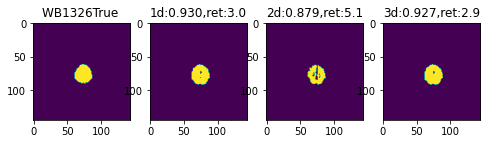

ret: 5.25405569637523 43.23114417580997
1.0
255.0


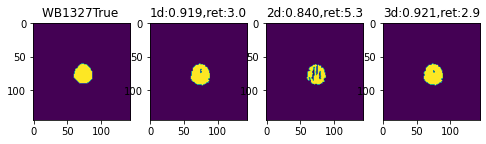

ret: 5.697136729371314 42.266607845530785
1.0
255.0


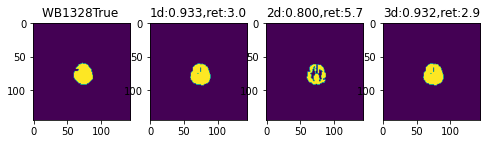

ret: 5.485435534458534 43.398416317210476
1.0
255.0


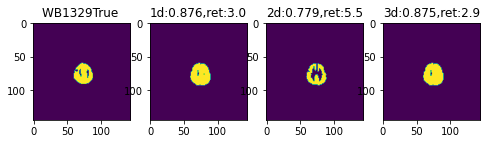

ret: 5.114858099993537 42.33042222565296
1.0
255.0


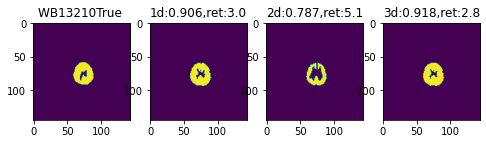

ret: 6.085758209228516 43.12814618278952
1.0
255.0


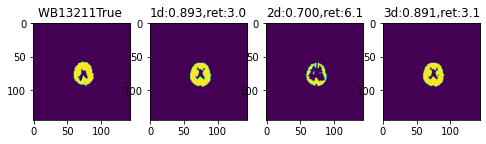

ret: 5.690529251098633 41.95577374626608
1.0
255.0


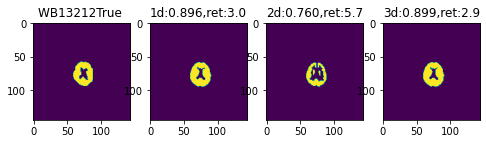

ret: 5.726568932626762 42.59605503456265
1.0
255.0


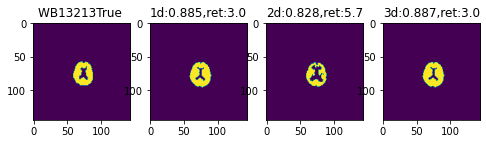

ret: 5.2963511149088545 40.63893372778799
1.0
255.0


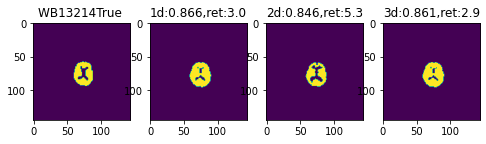

ret: 5.747430442361271 40.324712297028185
1.0
255.0


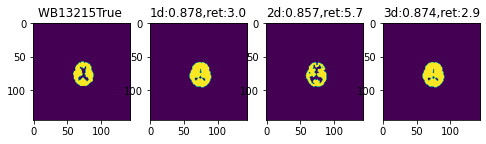

ret: 5.930513157564051 41.51405139997894
1.0
255.0


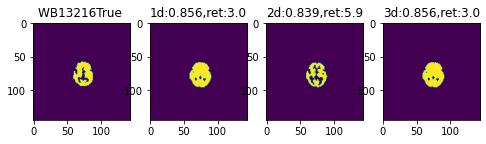

ret: 5.143590874765433 42.372872176824835
1.0
255.0


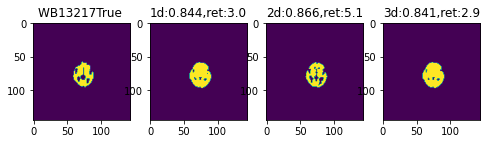

ret: 5.307938968434053 43.179877786075366
1.0
255.0


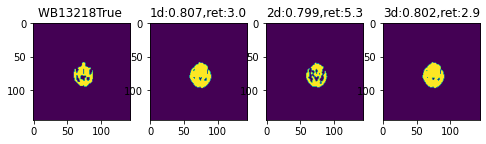

ret: 5.214612833658854 45.16965215346393
1.0
255.0


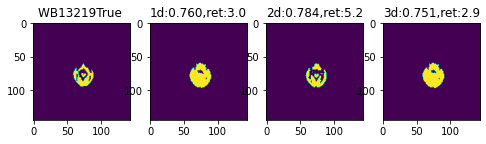

ret: 5.673370746537751 45.73295991187002
1.0
255.0


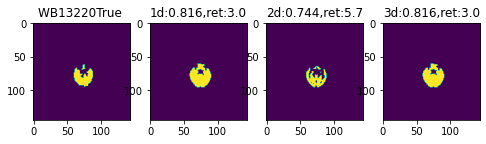

ret: 5.840422046885771 47.48527048148361
1.0
255.0


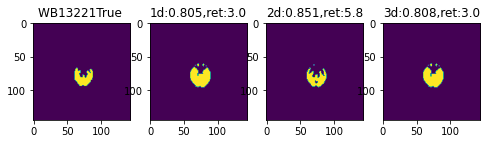

ret: 5.651936474968405 44.63521327598422
1.0
255.0


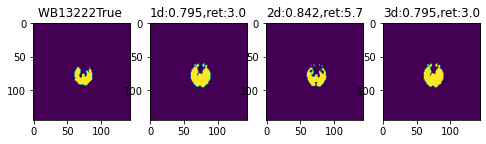

ret: 4.748005429436179 45.73628958907781
1.0
255.0


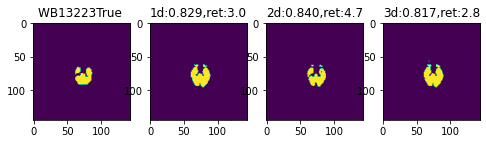

ret: 4.972115497963101 46.90786144780178
1.0
255.0


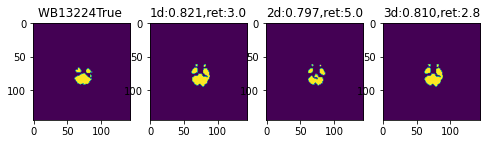

ret: 5.179827626546223 50.92120241651348
1.0
255.0


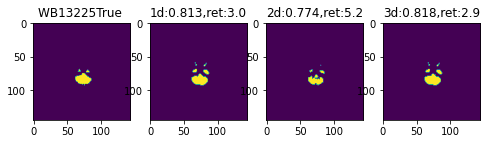

ret: 5.71724962720684 53.23713124593099
1.0
255.0


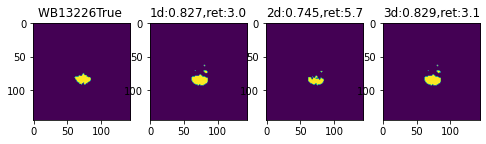

ret: 5.337564991969688 53.65477498372396
1.0
255.0


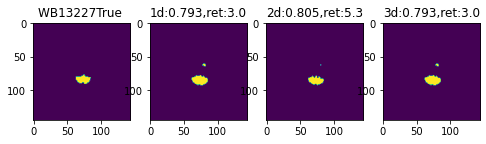

ret: 5.22873799941119 53.611192321777345
1.0
255.0


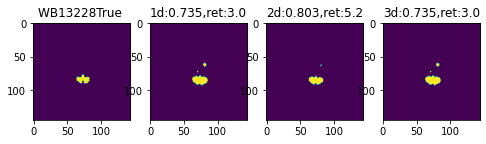

ret: 5.728936700259938 53.53068632238051
1.0
255.0


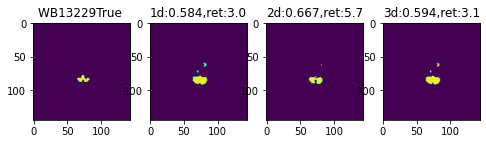

ret: 5.236594121596392 54.580859375
1.0
255.0


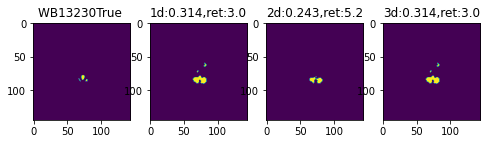

ret: 4.951620917226754 54.37021993001302
1.0
255.0


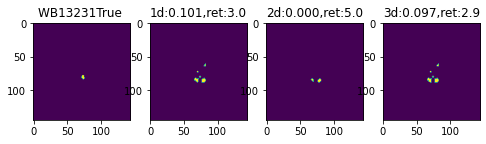

ret: 5.863778177897135 54.96581522623698
1.0
255.0


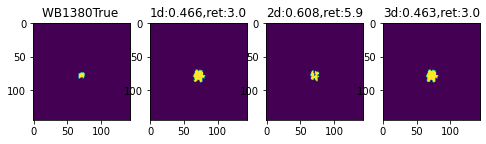

ret: 5.9675798303940715 53.73686762791054
1.0
255.0


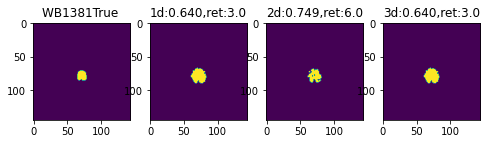

ret: 7.691959126790365 51.82830379710478
1.0
255.0


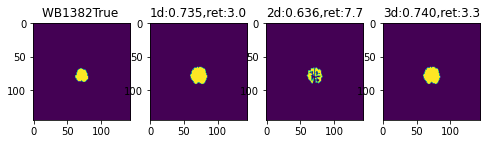

ret: 6.756092325846354 49.00833381204044
1.0
255.0


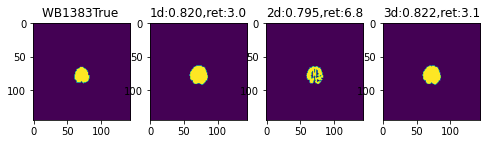

ret: 6.148530443976907 47.676777259976255
1.0
255.0


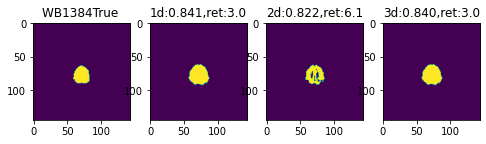

ret: 5.919065423105277 49.08917370964499
1.0
255.0


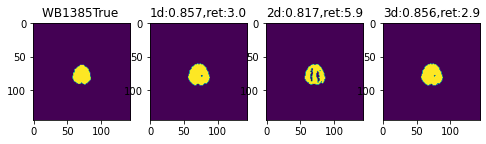

ret: 6.270901829588647 46.34852169261259
1.0
255.0


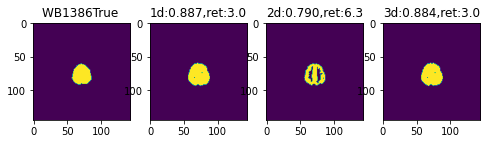

ret: 6.763090365540748 46.11560537300858
1.0
255.0


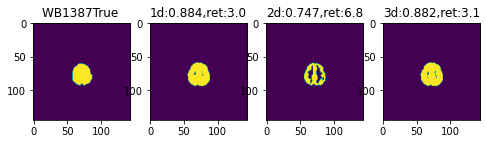

ret: 7.259441263535443 44.43335750804228
1.0
255.0


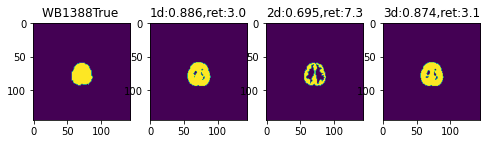

ret: 7.368003695618873 45.28055428897633
1.0
255.0


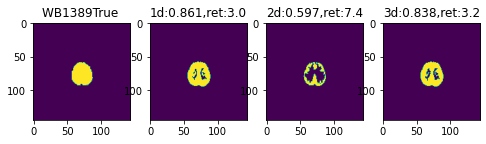

ret: 6.897610174440871 46.05380015653723
1.0
255.0


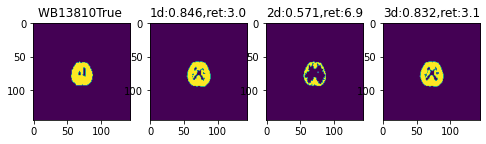

ret: 6.196796192842371 44.838127914129515
1.0
255.0


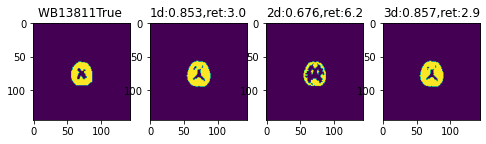

ret: 6.252906406626981 43.626698213465076
1.0
255.0


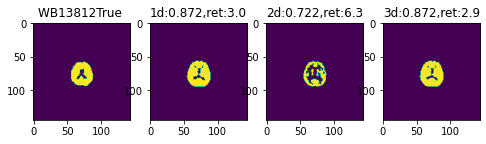

ret: 6.190304565429688 41.144045990588616
1.0
255.0


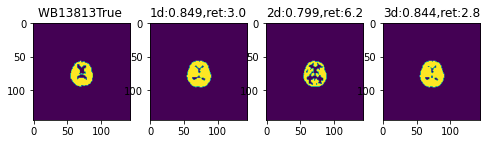

ret: 6.256596808340035 40.76271613625919
1.0
255.0


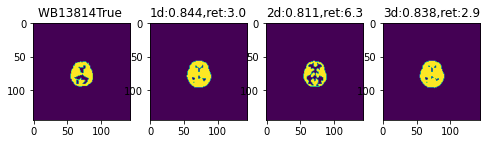

ret: 6.699487274768305 40.3739133348652
1.0
255.0


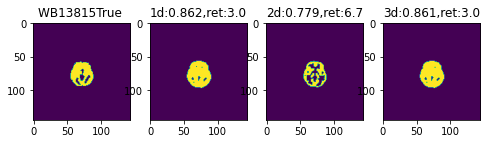

ret: 6.684700775146485 41.581588685278795
1.0
255.0


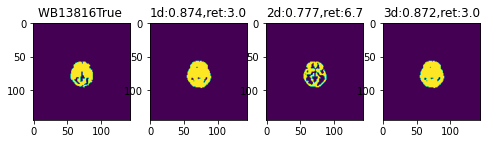

ret: 5.872055771771599 43.18674412147672
1.0
255.0


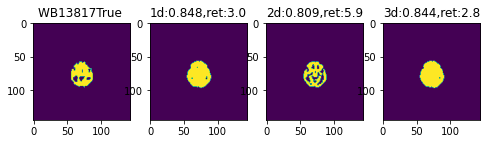

ret: 5.685674779555376 44.420177145565255
1.0
255.0


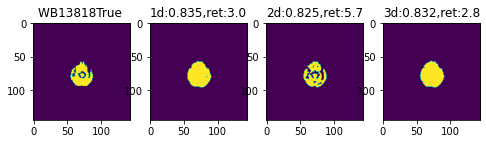

ret: 5.375220175350414 46.978604215734144
1.0
255.0


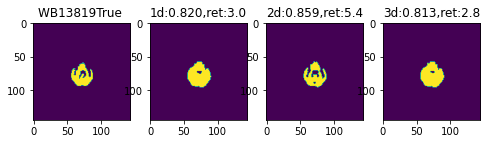

ret: 5.972809077244179 49.01516974954044
1.0
255.0


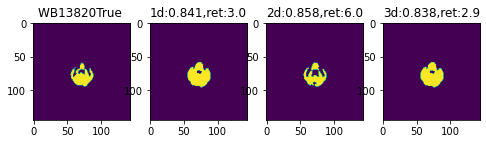

ret: 5.203069529813878 50.893152932559744
1.0
255.0


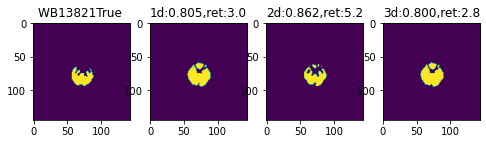

ret: 5.933434579886642 50.053957232306985
1.0
255.0


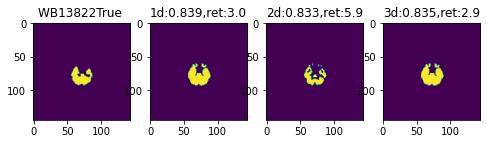

ret: 5.316256253859576 50.87908471799364
1.0
255.0


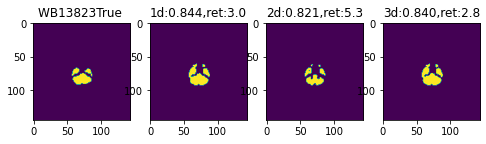

ret: 5.252939471076517 51.61534519569547
1.0
255.0


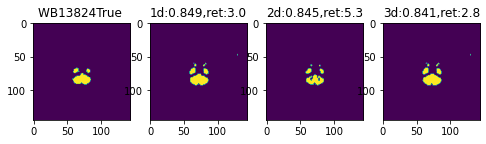

ret: 5.1898063958859915 51.826683044433594
1.0
255.0


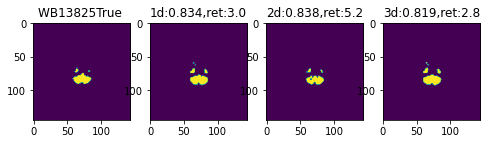

ret: 5.419464455398859 54.47187715418198
1.0
255.0


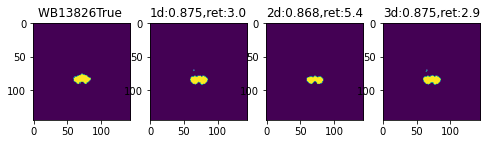

ret: 5.983018112182617 56.203501832251455
1.0
255.0


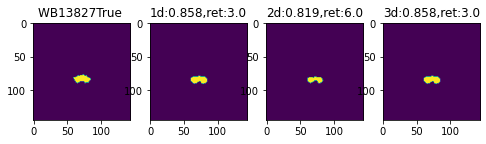

ret: 4.97730614157284 56.46412568933823
1.0
255.0


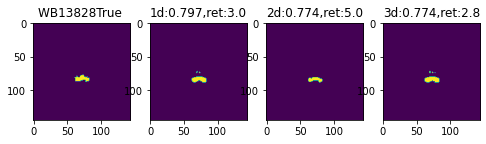

ret: 4.171418133903952 52.89794108072916
1.0
255.0


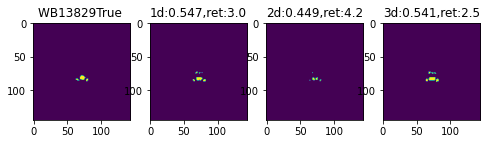

In [22]:
#dice計算_seki_endo

thSUV=3
WBkeys=list(WB_dic.keys())
dice_dic_a={}
dice_dic_b={}
dice_dic_c={}
ret1_dic={}
ret2_dic={}
ret_list=[3.27,2.73,3.19,3.55,3.2]
for q,WB in enumerate(WBkeys):
    dice_WB_a=[]
    dice_WB_b=[]
    dice_WB_c=[]
    ret1_WB_c=[]
    ret2_WB_c=[]
    imgsTrue=WB_dic[WB][0]
    imgsPT=WB_dic[WB][1]
    ret_kijun=ret_list[q]
    
    
    for i in range(len(imgsTrue)):
        imga=imgsTrue[i]
        imgPT=imgsPT[i]
        #方法1
        ret,imgb=method_th1(imgPT,thSUV)
        
        #方法2(ラプラシアン)
        ret1,imgc=method_th2_laphis(imgPT)
        
        #方法3(2回ラプラシアン)
        ret2,imgd=method4_double_laphis(imgPT)
        ret2,imgd=method_th1(imgPT,(ret2/255*imgPT.max()+ret_kijun)/2)
#         if ret_kijun+0.5<ret2/255*imgPT.max():
#             ret2,imgd=method_th1(imgPT,(ret2/255*imgPT.max()+ret_kijun+1)/2)
#         else:
#             ret2,imgd=method_th2_laphis(imgPT)
#             ret2=ret2/255*imgPT.max()

            
        print(imgb.max())
        print(imgc.max())
        #ret2,imgd=method4_double_laphis(imgPT)

        d1=Dice_Calculater(imga,imgb)
        d2=Dice_Calculater(imga,imgc)
        d3=Dice_Calculater(imga,imgd)
        dice_WB_a.append(d1)
        dice_WB_b.append(d2)
        dice_WB_c.append(d3)
        ret1_WB_c.append(ret1/255*imgPT.max())
        ret2_WB_c.append(ret2/255*imgPT.max())
        fig=plt.figure(figsize=(8,3))
        ax1=fig.add_subplot(141)
        plt.title(WB+str(i)+"True ")
        plt.imshow(imga)
        ax2=fig.add_subplot(142)
        plt.title("1d:{:.3f},ret:{:.1f}".format(d1,thSUV))
        plt.imshow(imgb)
        ax3=fig.add_subplot(143)
        plt.title("2d:{:.3f},ret:{:.1f}".format(d2,ret1/255*imgPT.max()))
        plt.imshow(imgc)
        ax4=fig.add_subplot(144)
        #plt.title("3d:{:.3f},ret:{:.1f}".format(d3,ret2/255*imgPT.max()))
        plt.title("3d:{:.3f},ret:{:.1f}".format(d3,ret2))
        plt.imshow(imgd)
        plt.show()
    dice_dic_a[WB]=dice_WB_a
    dice_dic_b[WB]=dice_WB_b
    dice_dic_c[WB]=dice_WB_c
    ret1_dic[WB]=ret1_WB_c
    ret2_dic[WB]=ret2_WB_c

ret: 3.2440502391142 54.38474629720052
1.0
255.0


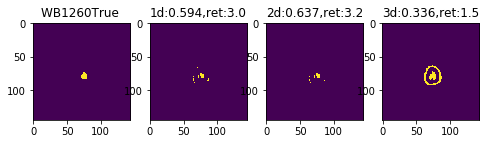

ret: 4.998194167193245 51.44212072035846
1.0
255.0


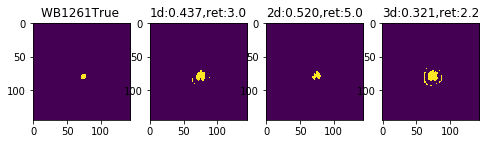

ret: 5.268510425792021 52.71016737994025
1.0
255.0


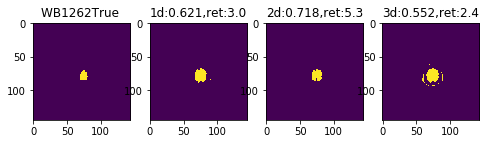

ret: 5.3612548828125 49.62614770029106
1.0
255.0


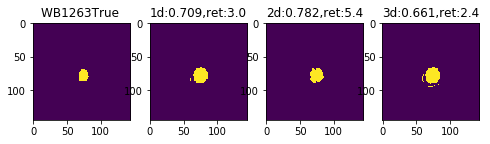

ret: 5.284846062753715 49.56297287286497
1.0
255.0


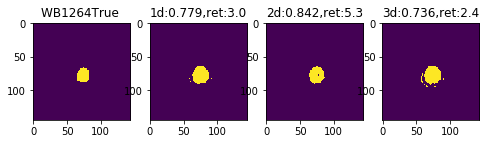

ret: 5.04130906123741 46.80025562959559
1.0
255.0


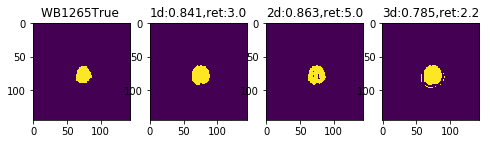

ret: 5.188868967692057 46.75600774428423
1.0
255.0


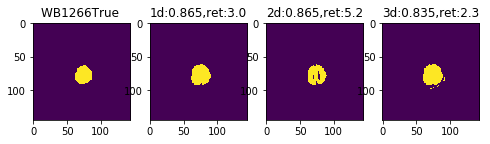

ret: 5.312291538014131 45.088350782207414
1.0
255.0


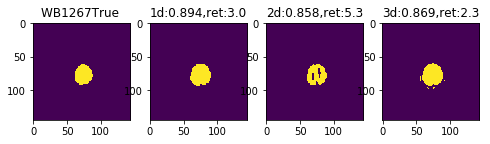

1.0
255.0


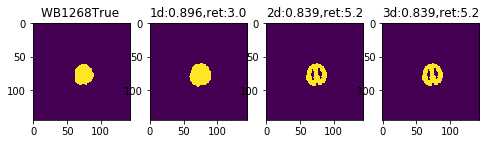

ret: 5.407004300285788 46.88448576085708
1.0
255.0


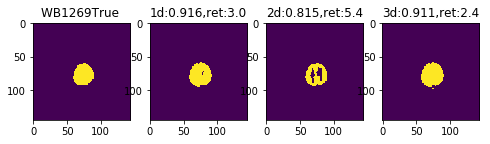

ret: 5.776732500861673 49.05581712909773
1.0
255.0


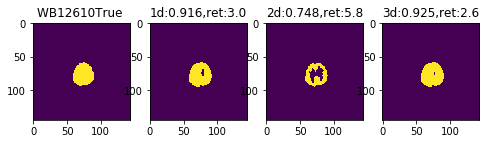

ret: 5.454066298989688 48.62056328268612
1.0
255.0


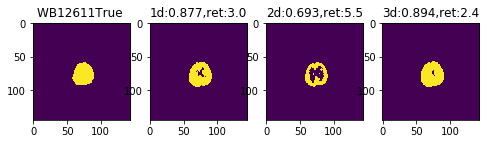

ret: 5.869834466074027 47.856438131893384
1.0
255.0


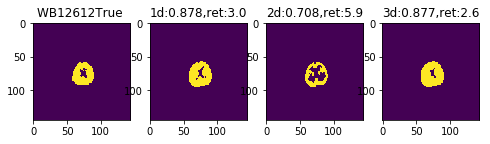

ret: 5.467068399167529 46.12832740334903
1.0
255.0


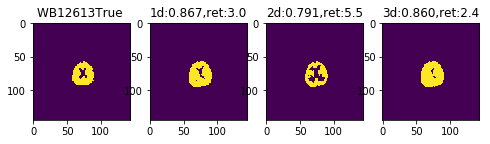

ret: 5.846936887853286 45.13751513911228
1.0
255.0


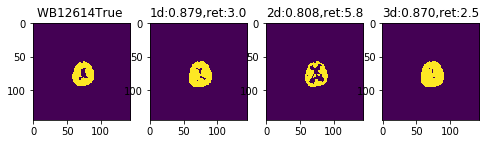

ret: 6.192684368058747 44.422316128599874
1.0
255.0


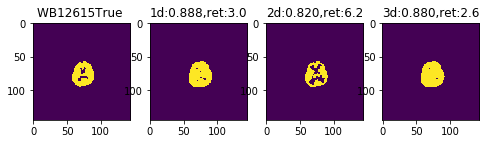

ret: 6.0826052160824045 44.28266039081649
1.0
255.0


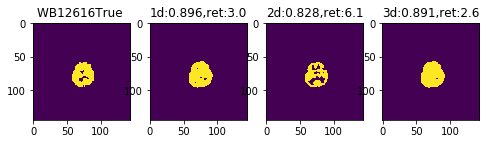

ret: 5.994049790326287 44.81642928777957
1.0
255.0


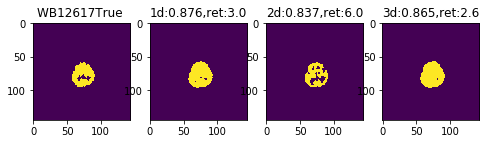

ret: 5.519977442423503 46.55073385799632
1.0
255.0


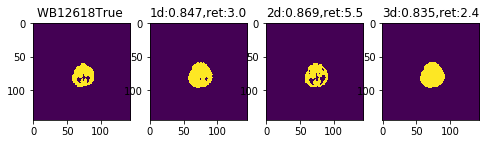

ret: 5.9721767911724015 46.95486510033701
1.0
255.0


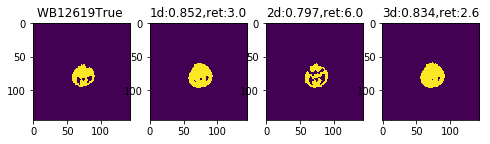

ret: 6.365160362393248 48.3042054419424
1.0
255.0


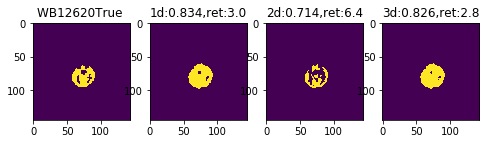

ret: 6.3724873150096215 47.777824850643384
1.0
255.0


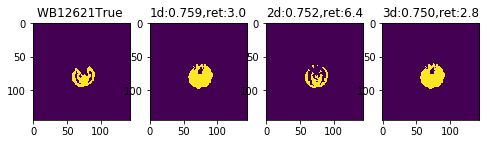

ret: 5.904966376809512 47.282202627144606
1.0
255.0


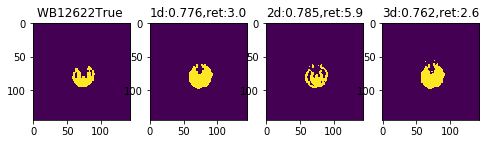

ret: 6.203711244171741 49.13830701042624
1.0
255.0


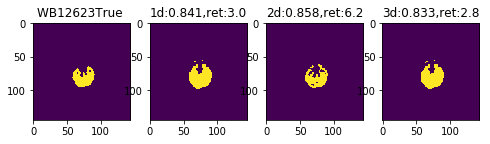

ret: 6.405492906009449 50.04379107905369
1.0
255.0


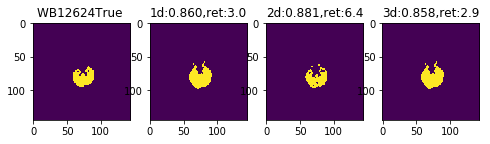

ret: 6.740657757777793 50.633411332672715
1.0
255.0


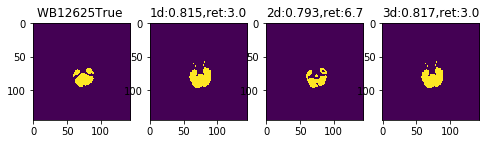

ret: 6.25715165979722 53.14987487792969
1.0
255.0


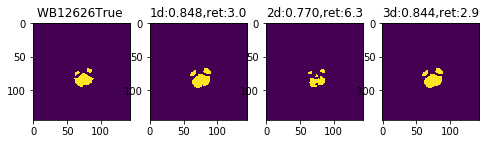

ret: 6.685447064568015 54.91842783011642
1.0
255.0


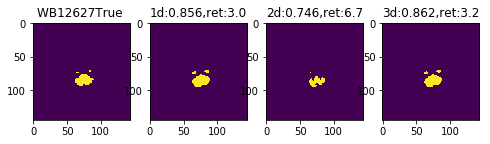

ret: 5.356657046897738 53.59303436279297
1.0
255.0


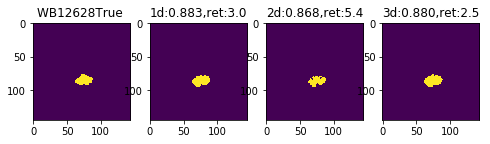

ret: 5.359185746136833 53.42356357948453
1.0
255.0


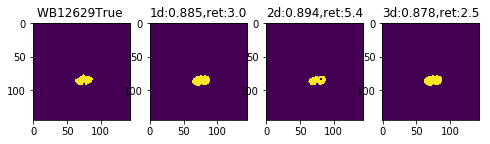

ret: 5.184208454805262 54.68427949793198
1.0
255.0


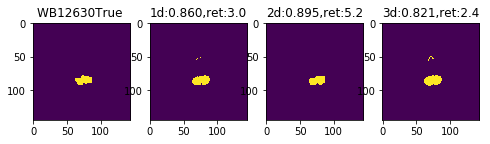

ret: 5.0011172238518204 52.97830188227635
1.0
255.0


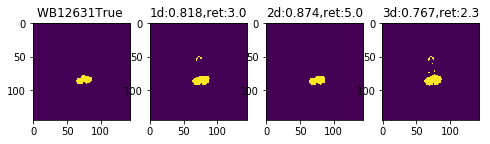

ret: 5.1808124617034315 54.702103917738974
1.0
255.0


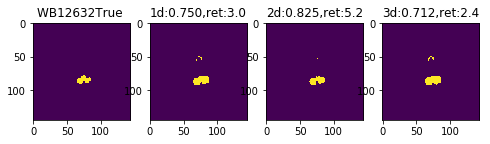

ret: 5.468842203476849 55.27661626479205
1.0
255.0


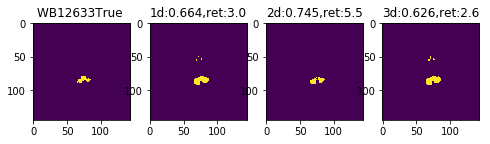

1.0
255.0


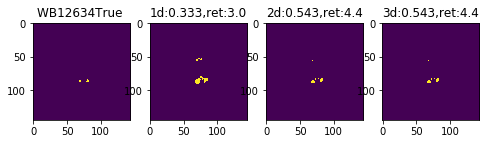

ret: 4.685652340159697 56.251716164981616
1.0
255.0


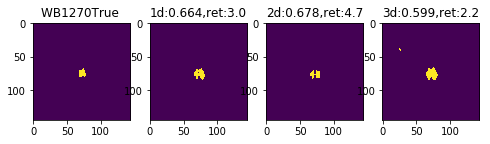

ret: 4.620521119061639 53.86348867977367
1.0
255.0


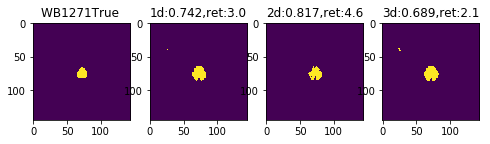

ret: 4.7153112299302045 53.65996345071231
1.0
255.0


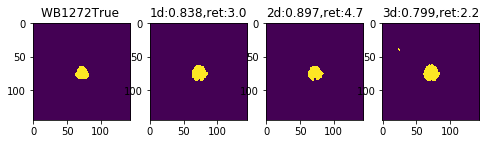

ret: 4.447104341843549 53.578504435221355
1.0
255.0


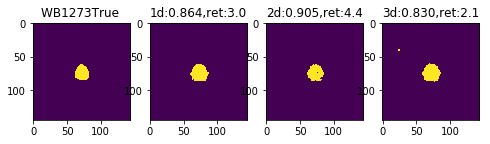

ret: 4.5407451629638675 52.50886601466759
1.0
255.0


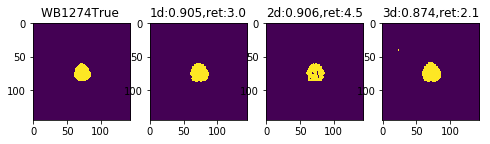

ret: 4.506273587544759 51.531845182531015
1.0
255.0


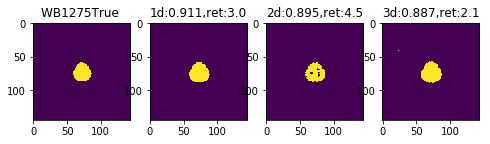

ret: 4.243918549780752 48.542374375287224
1.0
255.0


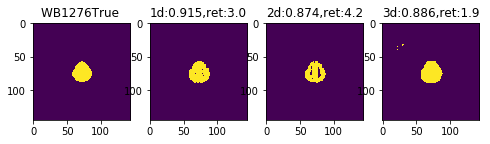

ret: 4.27206594803754 48.57881523581112
1.0
255.0


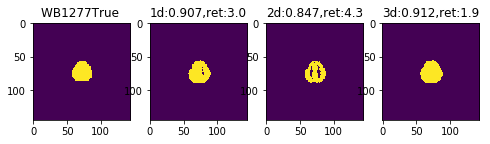

ret: 4.694948906991996 48.2631898169424
1.0
255.0


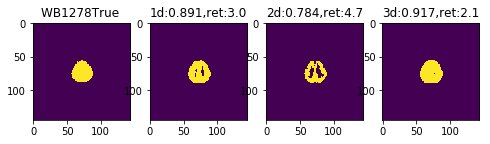

ret: 4.936978598201976 48.29752508425245
1.0
255.0


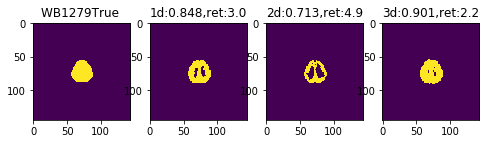

ret: 4.698756722842946 48.12646436504289
1.0
255.0


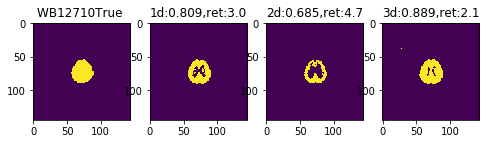

ret: 4.028009740044089 49.134797488941864
1.0
255.0


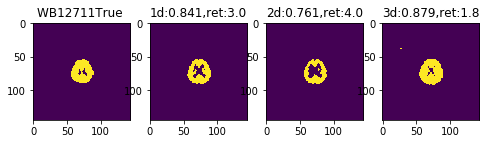

ret: 3.945358085632324 47.74705978094363
1.0
255.0


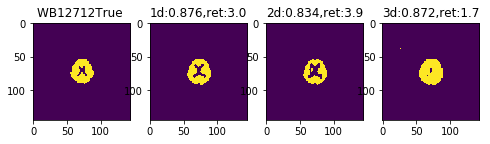

ret: 4.93426939646403 46.105531281115965
1.0
255.0


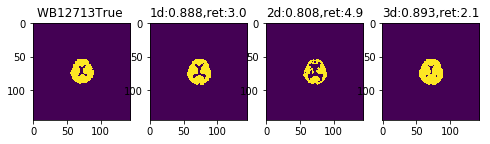

ret: 5.067555917478075 46.4880791757621
1.0
255.0


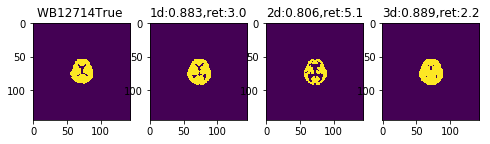

ret: 4.521715680290671 46.13848975686466
1.0
255.0


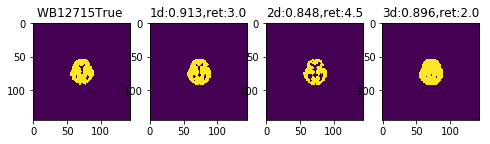

ret: 4.711352404426126 45.247286867627906
1.0
255.0


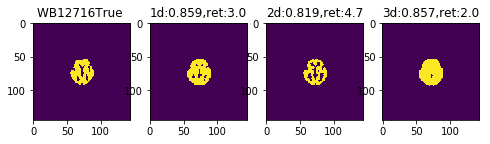

ret: 5.017955185385311 45.65977875952627
1.0
255.0


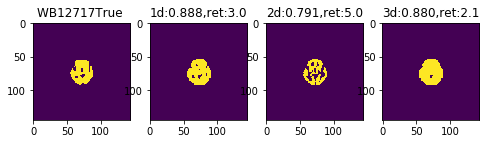

ret: 4.683275656606637 45.68639334884344
1.0
255.0


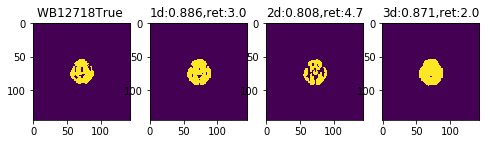

ret: 5.004909706115723 48.23538513183594
1.0
255.0


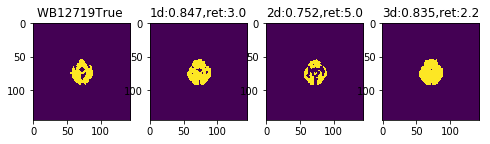

ret: 4.2700141831940295 48.721695664349724
1.0
255.0


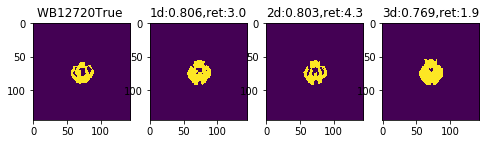

ret: 4.271657427619486 51.37394445082721
1.0
255.0


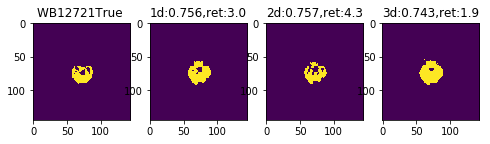

ret: 4.017064262838925 50.899379057042744
1.0
255.0


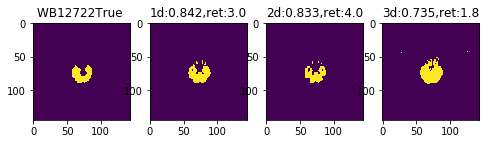

ret: 3.9519800298354206 51.806510775697
1.0
255.0


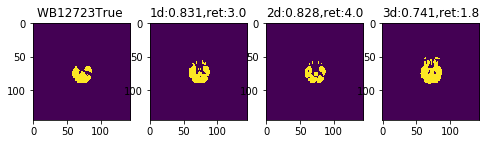

ret: 4.3352402930166205 53.12793300853056
1.0
255.0


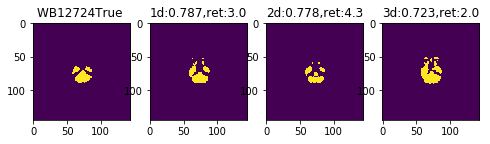

ret: 4.010606743307674 54.224952697753906
1.0
255.0


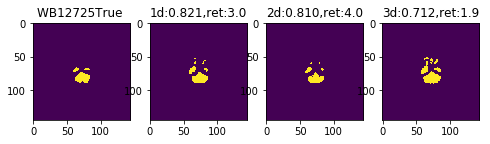

ret: 3.9684199763279335 56.17652025409774
1.0
255.0


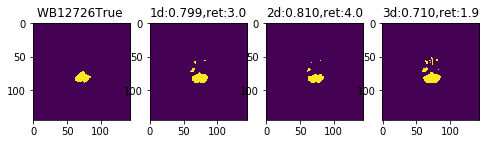

ret: 4.117472734638289 57.15991755466835
1.0
255.0


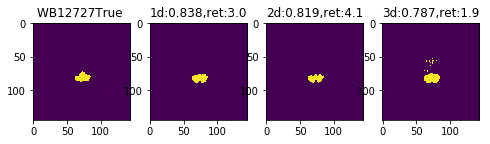

ret: 4.087083752950033 54.82054799397787
1.0
255.0


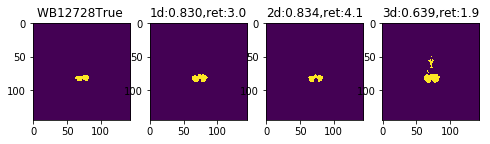

ret: 4.396344502766927 56.731283389820774
1.0
255.0


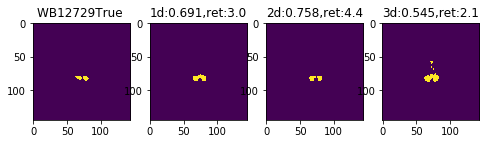

1.0
255.0


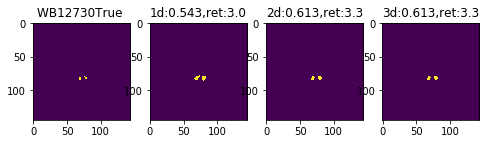

ret: 3.9246912039962467 48.00683629653033
1.0
255.0


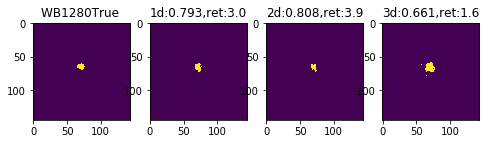

1.0
255.0


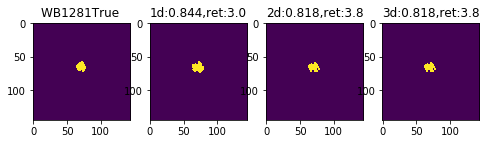

ret: 3.742675242704504 48.157838709214154
1.0
255.0


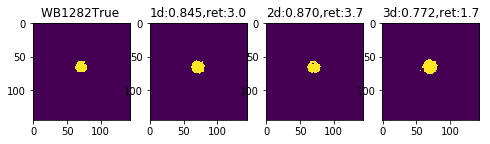

1.0
255.0


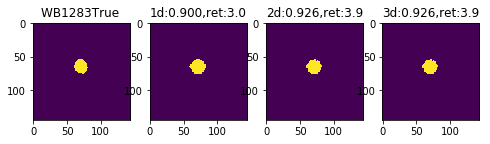

ret: 3.6879748924105775 40.61631954417509
1.0
255.0


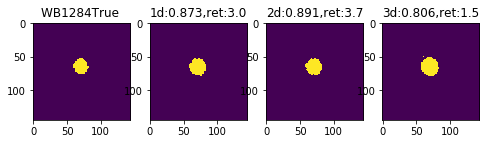

1.0
255.0


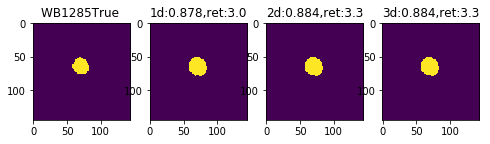

ret: 3.5076911028693702 36.40553193933823
1.0
255.0


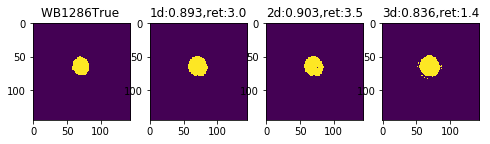

1.0
255.0


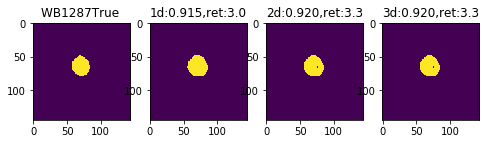

ret: 3.5556585274490655 36.28754631491269
1.0
255.0


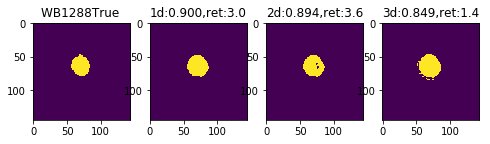

1.0
255.0


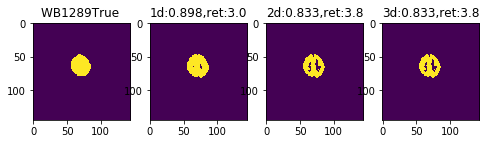

ret: 3.6109400431315106 35.71892568550858
1.0
255.0


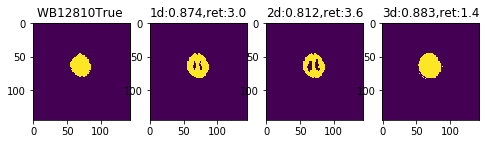

1.0
255.0


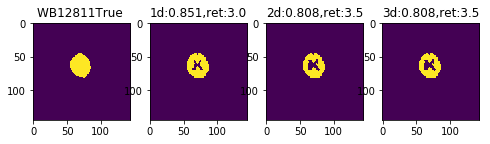

ret: 3.4602268144196153 33.89416240617341
1.0
255.0


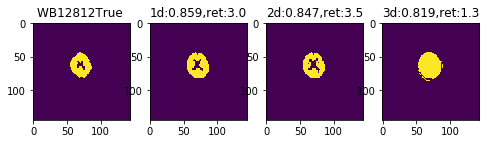

1.0
255.0


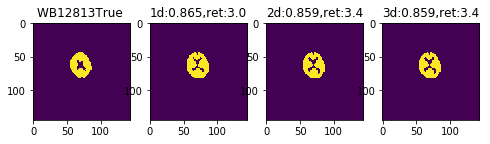

ret: 3.9552463419297164 33.15894129136029
1.0
255.0


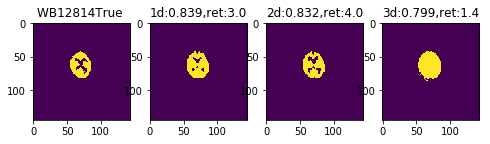

1.0
255.0


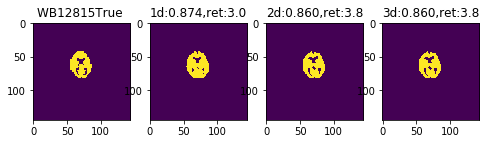

ret: 3.8205679014617324 33.17597009995404
1.0
255.0


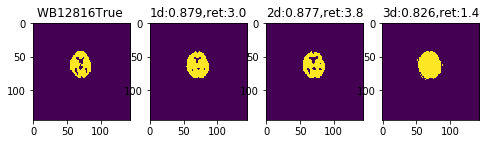

1.0
255.0


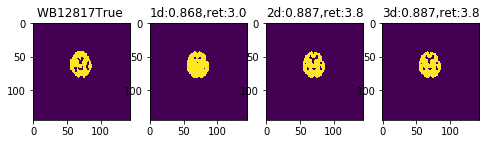

ret: 3.704416222665824 34.19675520354626
1.0
255.0


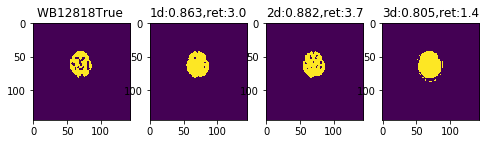

1.0
255.0


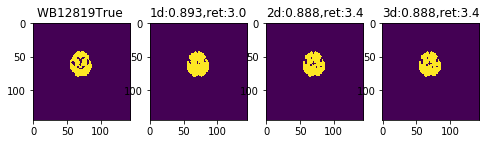

ret: 3.5136173659679937 35.330364750880825
1.0
255.0


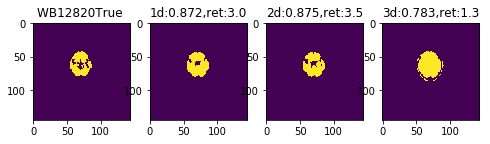

1.0
255.0


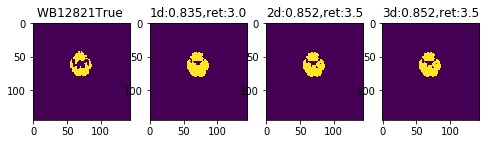

ret: 3.606432372448491 36.77868293313419
1.0
255.0


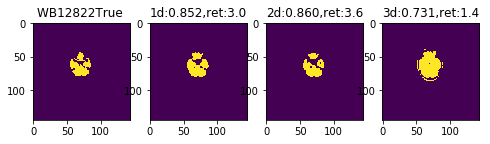

1.0
255.0


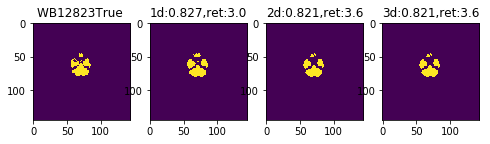

ret: 3.679937276653215 41.140414129518994
1.0
255.0


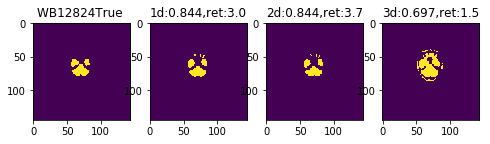

1.0
255.0


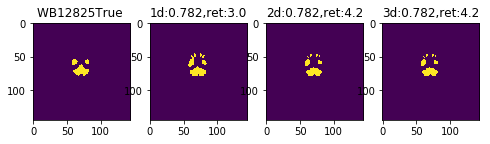

ret: 3.841123562233121 42.68977876551011
1.0
255.0


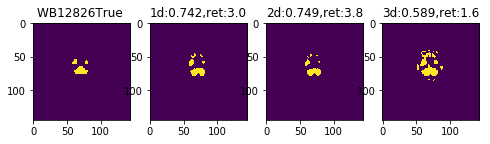

1.0
255.0


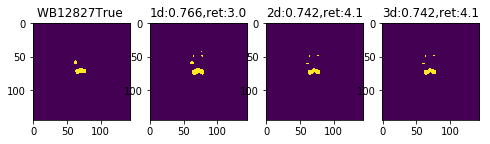

ret: 3.4572786892161647 49.152351977778416
1.0
255.0


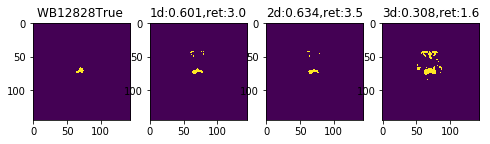

1.0
255.0


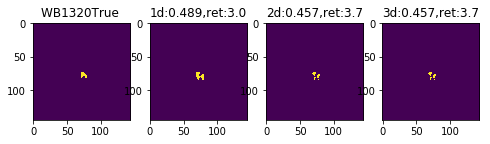

ret: 5.384268801820045 53.61711677102481
1.0
255.0


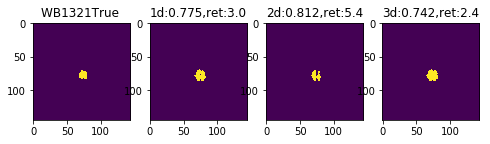

ret: 5.792314260146197 51.85253822476256
1.0
255.0


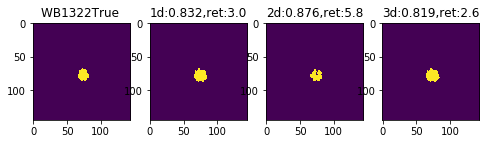

1.0
255.0


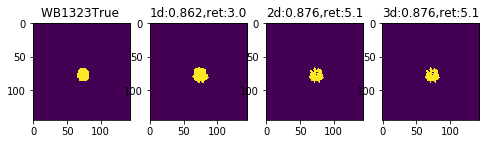

ret: 5.376617311963848 48.53321605009191
1.0
255.0


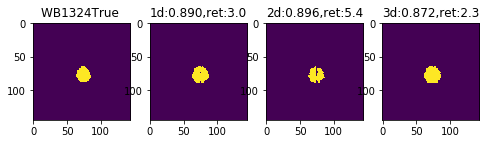

1.0
255.0


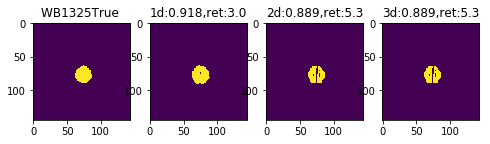

ret: 5.128561760397519 44.85854133157169
1.0
255.0


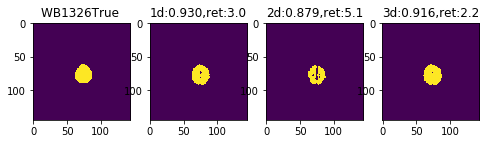

1.0
255.0


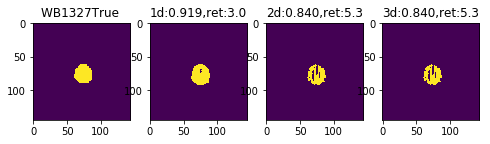

ret: 5.697136729371314 42.266607845530785
1.0
255.0


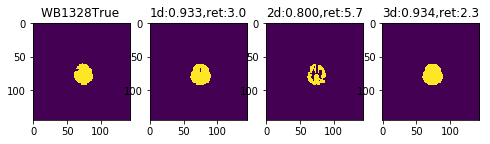

1.0
255.0


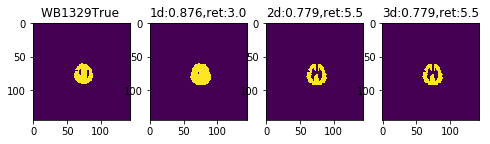

ret: 5.114858099993537 42.33042222565296
1.0
255.0


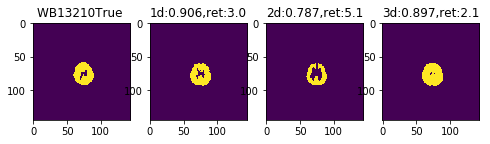

1.0
255.0


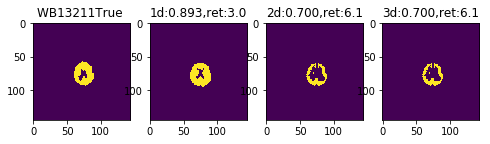

ret: 5.690529251098633 41.95577374626608
1.0
255.0


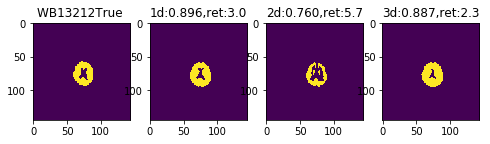

1.0
255.0


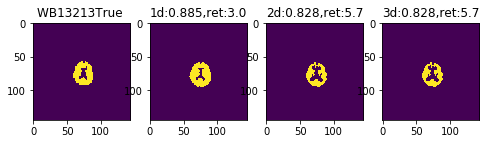

ret: 5.2963511149088545 40.63893372778799
1.0
255.0


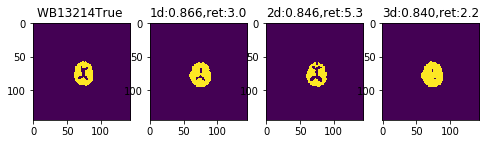

1.0
255.0


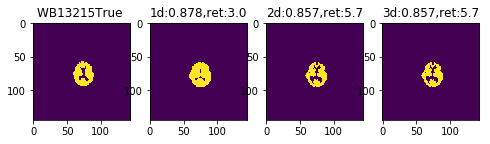

ret: 5.930513157564051 41.51405139997894
1.0
255.0


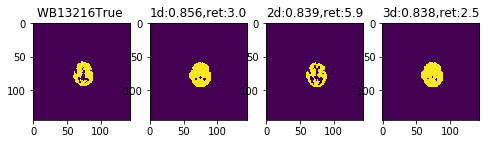

1.0
255.0


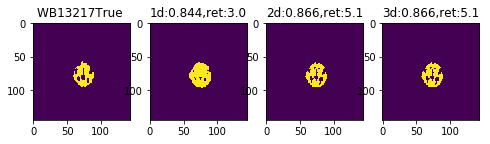

ret: 5.307938968434053 43.179877786075366
1.0
255.0


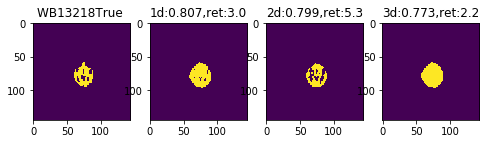

1.0
255.0


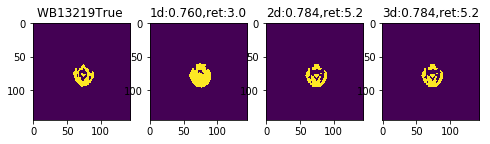

ret: 5.673370746537751 45.73295991187002
1.0
255.0


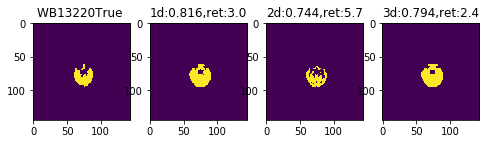

1.0
255.0


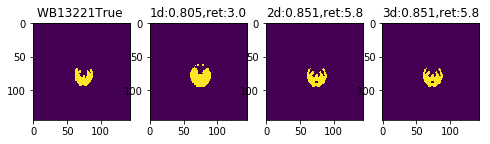

ret: 5.651936474968405 44.63521327598422
1.0
255.0


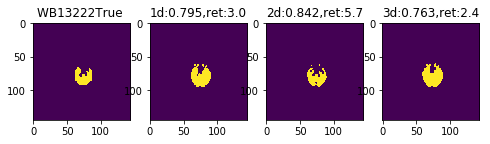

1.0
255.0


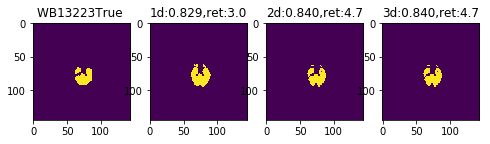

ret: 4.972115497963101 46.90786144780178
1.0
255.0


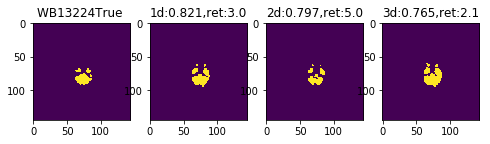

1.0
255.0


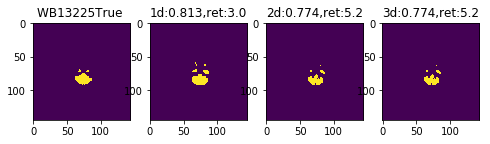

ret: 5.71724962720684 53.23713124593099
1.0
255.0


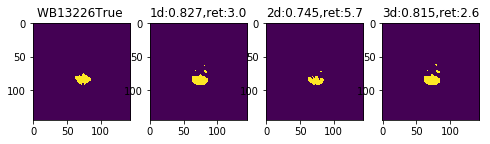

1.0
255.0


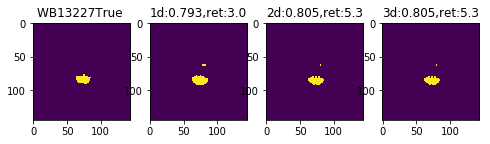

ret: 5.22873799941119 53.611192321777345
1.0
255.0


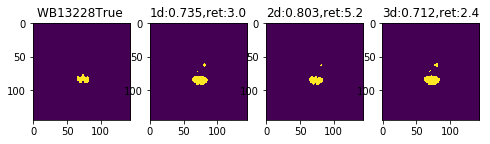

ret: 5.728936700259938 53.53068632238051
1.0
255.0


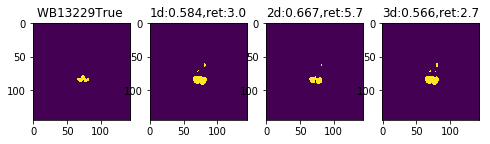

1.0
255.0


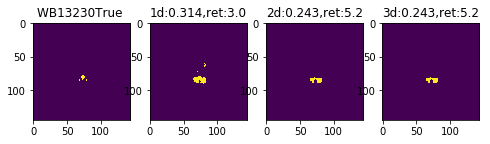

ret: 4.951620917226754 54.37021993001302
1.0
255.0


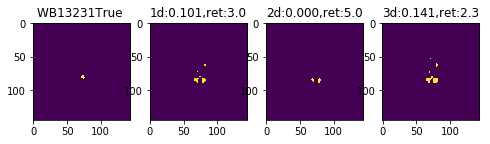

ret: 5.863778177897135 54.96581522623698
1.0
255.0


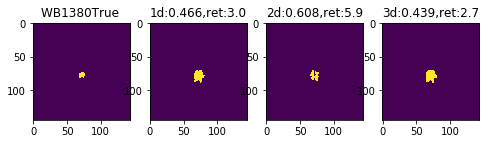

ret: 5.9675798303940715 53.73686762791054
1.0
255.0


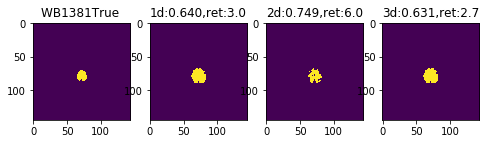

ret: 7.691959126790365 51.82830379710478
1.0
255.0


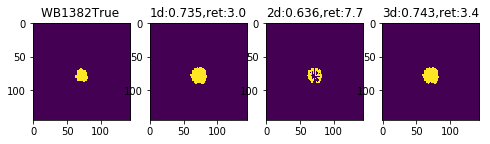

ret: 6.756092325846354 49.00833381204044
1.0
255.0


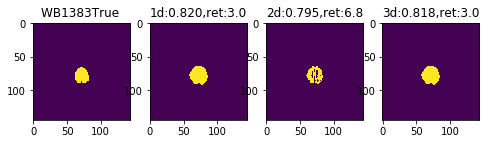

ret: 6.148530443976907 47.676777259976255
1.0
255.0


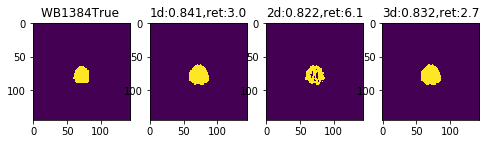

ret: 5.919065423105277 49.08917370964499
1.0
255.0


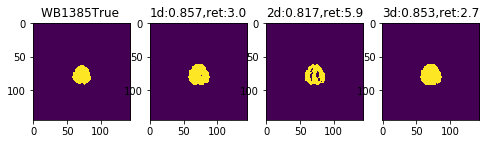

ret: 6.270901829588647 46.34852169261259
1.0
255.0


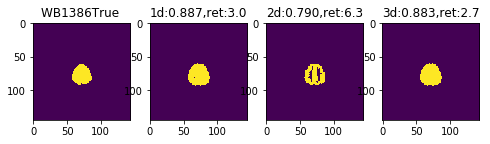

ret: 6.763090365540748 46.11560537300858
1.0
255.0


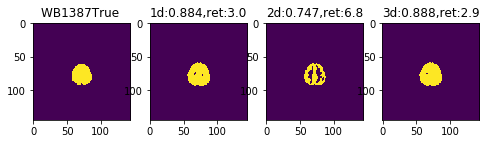

ret: 7.259441263535443 44.43335750804228
1.0
255.0


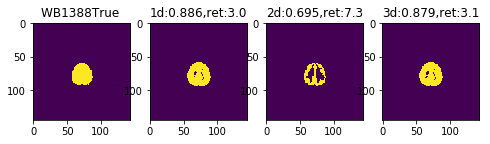

ret: 7.368003695618873 45.28055428897633
1.0
255.0


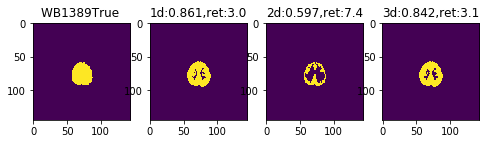

ret: 6.897610174440871 46.05380015653723
1.0
255.0


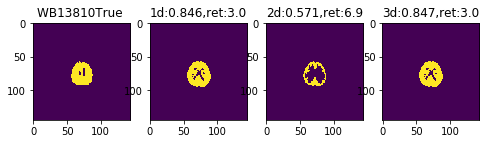

ret: 6.196796192842371 44.838127914129515
1.0
255.0


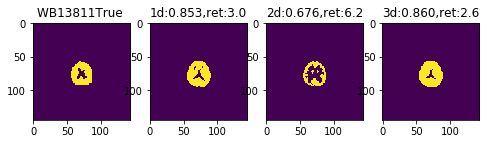

ret: 6.252906406626981 43.626698213465076
1.0
255.0


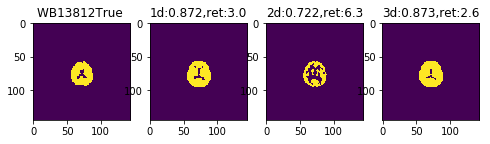

ret: 6.190304565429688 41.144045990588616
1.0
255.0


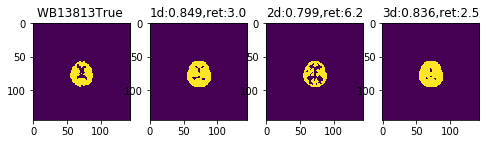

ret: 6.256596808340035 40.76271613625919
1.0
255.0


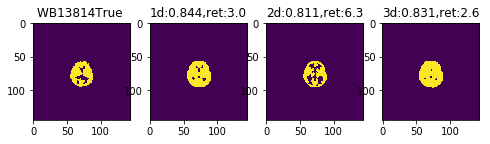

ret: 6.699487274768305 40.3739133348652
1.0
255.0


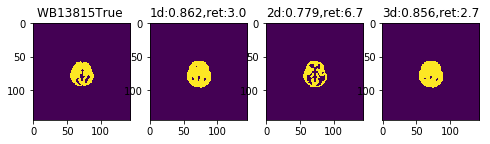

ret: 6.684700775146485 41.581588685278795
1.0
255.0


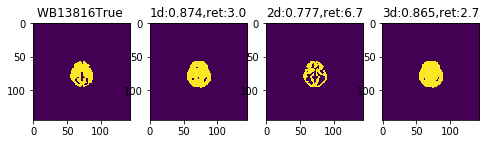

ret: 5.872055771771599 43.18674412147672
1.0
255.0


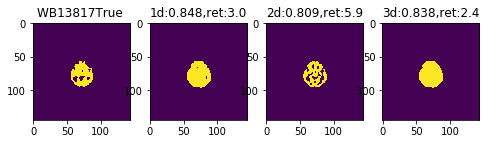

ret: 5.685674779555376 44.420177145565255
1.0
255.0


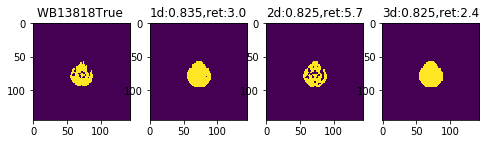

ret: 5.375220175350414 46.978604215734144
1.0
255.0


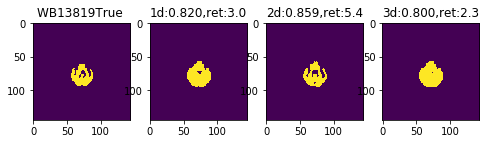

ret: 5.972809077244179 49.01516974954044
1.0
255.0


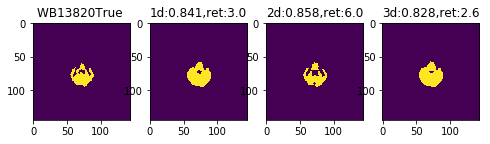

ret: 5.203069529813878 50.893152932559744
1.0
255.0


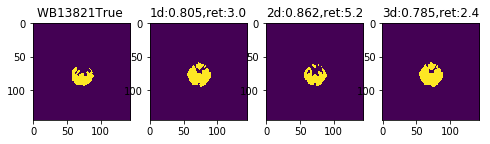

ret: 5.933434579886642 50.053957232306985
1.0
255.0


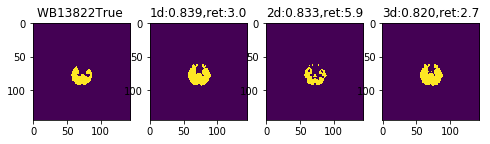

ret: 5.316256253859576 50.87908471799364
1.0
255.0


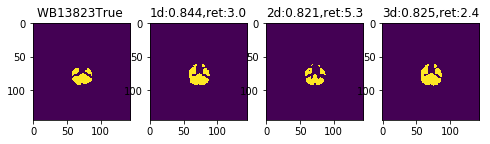

ret: 5.252939471076517 51.61534519569547
1.0
255.0


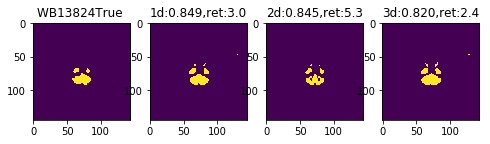

ret: 5.1898063958859915 51.826683044433594
1.0
255.0


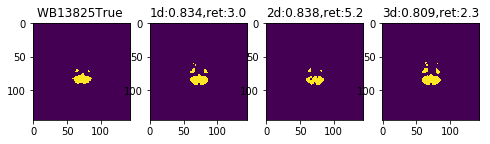

ret: 5.419464455398859 54.47187715418198
1.0
255.0


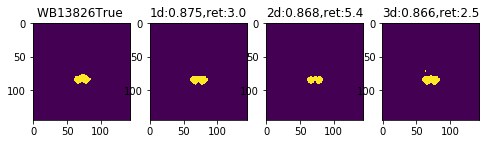

ret: 5.983018112182617 56.203501832251455
1.0
255.0


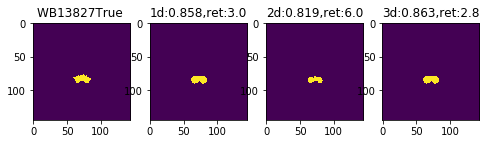

ret: 4.97730614157284 56.46412568933823
1.0
255.0


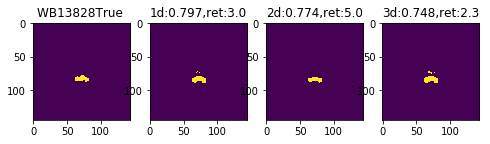

1.0
255.0


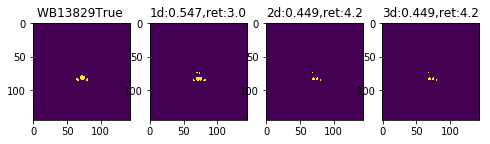

In [76]:
#dice計算_seki

thSUV=3
WBkeys=list(WB_dic.keys())
dice_dic_a={}
dice_dic_b={}
dice_dic_c={}
ret1_dic={}
ret2_dic={}
ret_list=[2.27,1.73,2.19,2.55,2.2]
for q,WB in enumerate(WBkeys):
    dice_WB_a=[]
    dice_WB_b=[]
    dice_WB_c=[]
    ret1_WB_c=[]
    ret2_WB_c=[]
    imgsTrue=WB_dic[WB][0]
    imgsPT=WB_dic[WB][1]
    ret_kijun=ret_list[q]
    
    
    for i in range(len(imgsTrue)):
        imga=imgsTrue[i]
        imgPT=imgsPT[i]
        ret,imgb=method_th1(imgPT,thSUV)
        
        ret1,imgc=method_th2_laphis(imgPT)
        if ret_kijun<ret2/255*imgPT.max():
            ret2,imgd=method4_double_laphis(imgPT)
        else:
            ret2,imgd=method_th2_laphis(imgPT)

            
        print(imgb.max())
        print(imgc.max())
        #ret2,imgd=method4_double_laphis(imgPT)

        d1=Dice_Calculater(imga,imgb)
        d2=Dice_Calculater(imga,imgc)
        d3=Dice_Calculater(imga,imgd)
        dice_WB_a.append(d1)
        dice_WB_b.append(d2)
        dice_WB_c.append(d3)
        ret1_WB_c.append(ret1/255*imgPT.max())
        ret2_WB_c.append(ret2/255*imgPT.max())
        fig=plt.figure(figsize=(8,3))
        ax1=fig.add_subplot(141)
        plt.title(WB+str(i)+"True ")
        plt.imshow(imga)
        ax2=fig.add_subplot(142)
        plt.title("1d:{:.3f},ret:{:.1f}".format(d1,thSUV))
        plt.imshow(imgb)
        ax3=fig.add_subplot(143)
        plt.title("2d:{:.3f},ret:{:.1f}".format(d2,ret1/255*imgPT.max()))
        plt.imshow(imgc)
        ax4=fig.add_subplot(144)
        plt.title("3d:{:.3f},ret:{:.1f}".format(d3,ret2/255*imgPT.max()))
        plt.imshow(imgd)
        plt.show()
    dice_dic_a[WB]=dice_WB_a
    dice_dic_b[WB]=dice_WB_b
    dice_dic_c[WB]=dice_WB_c
    ret1_dic[WB]=ret1_WB_c
    ret2_dic[WB]=ret2_WB_c

In [1]:
#dice計算

thSUV=3
WBkeys=list(WB_dic.keys())
dice_dic_a={}
dice_dic_b={}
dice_dic_c={}
ret1_dic={}
ret2_dic={}
ret_list=[2.27,1.73,2.19,2.55,2.2]
for WB in WBkeys:
    dice_WB_a=[]
    dice_WB_b=[]
    dice_WB_c=[]
    ret1_WB_c=[]
    ret2_WB_c=[]
    imgsTrue=WB_dic[WB][0]
    imgsPT=WB_dic[WB][1]

    for i in range(len(imgsTrue)):
        imga=imgsTrue[i]
        imgPT=imgsPT[i]
        ret,imgb=method_th1(imgPT,thSUV)
        
        ret1,imgc=method_th2_laphis(imgPT)
#         if 6<i<15:
#             ret2,imgd=method4_double_laphis(imgPT)
#         else:
#             ret2,imgd=method_th2_laphis(imgPT)
        ret2,imgd=method4_double_laphis(imgPT)
        print(imgb.max())
        print(imgc.max())


        d1=Dice_Calculater(imga,imgb)
        d2=Dice_Calculater(imga,imgc)
        d3=Dice_Calculater(imga,imgd)
        dice_WB_a.append(d1)
        dice_WB_b.append(d2)
        dice_WB_c.append(d3)
        ret1_WB_c.append(ret1/255*imgPT.max())
        ret2_WB_c.append(ret2/255*imgPT.max())
        fig=plt.figure(figsize=(8,3))
        ax1=fig.add_subplot(141)
        plt.title(WB+str(i)+"True ")
        plt.imshow(imga)
        ax2=fig.add_subplot(142)
        plt.title("1d:{:.3f},ret:{:.1f}".format(d1,thSUV))
        plt.imshow(imgb)
        ax3=fig.add_subplot(143)
        plt.title("2d:{:.3f},ret:{:.1f}".format(d2,ret1/255*imgPT.max()))
        plt.imshow(imgc)
        ax4=fig.add_subplot(144)
        plt.title("3d:{:.3f},ret:{:.1f}".format(d3,ret2/255*imgPT.max()))
        plt.imshow(imgd)
        plt.show()
    dice_dic_a[WB]=dice_WB_a
    dice_dic_b[WB]=dice_WB_b
    dice_dic_c[WB]=dice_WB_c
    ret1_dic[WB]=ret1_WB_c
    ret2_dic[WB]=ret2_WB_c

NameError: name 'WB_dic' is not defined

WB126 0.841±0.064
WB127 0.855±0.042
WB128 0.861±0.038
WB132 0.842±0.072
WB138 0.847±0.031


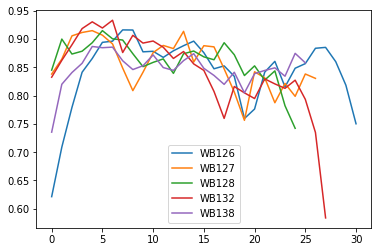

WB126   WB127   WB128   WB132   WB138
0   0.6212  0.8379  0.8449  0.8323  0.7352
1   0.7087  0.8643  0.8997  0.8622  0.8199
2   0.7790  0.9055  0.8733  0.8897  0.8406
3   0.8411  0.9114  0.8783  0.9183  0.8569
4   0.8654  0.9147  0.8933  0.9302  0.8867
5   0.8940  0.9066  0.9147  0.9193  0.8845
6   0.8960  0.8912  0.9002  0.9330  0.8855
7   0.9160  0.8484  0.8980  0.8760  0.8614
8   0.9158  0.8086  0.8739  0.9064  0.8458
9   0.8772  0.8410  0.8510  0.8927  0.8526
10  0.8782  0.8758  0.8586  0.8963  0.8717
11  0.8674  0.8885  0.8647  0.8853  0.8494
12  0.8790  0.8829  0.8391  0.8655  0.8444
13  0.8880  0.9134  0.8738  0.8777  0.8617
14  0.8961  0.8593  0.8786  0.8558  0.8739
15  0.8757  0.8880  0.8683  0.8444  0.8481
16  0.8472  0.8860  0.8632  0.8072  0.8355
17  0.8524  0.8471  0.8933  0.7595  0.8197
18  0.8339  0.8062  0.8721  0.8159  0.8411
19  0.7593  0.7561  0.8353  0.8047  0.8046
20  0.7761  0.8419  0.8524  0.7946  0.8386
21  0.8413  0.8313  0.8273  0.8294  0.8443
22  0.8604  0.7872  0.8435  0.8205  0.8489
23  0.8152  0.8213  0.7819  0.8127  0.8341
24  0.8482  0.7985  0.7420  0.8271  0.8745
25  0.8563  0.8380     NaN  0.7932  0.8578
26  0.8835  0.8303     NaN  0.7346     NaN
27  0.8851     NaN     NaN  0.5836     NaN
28  0.8598     NaN     NaN     NaN     NaN
29  0.8182     NaN     NaN     NaN     NaN
30  0.7500     NaN     NaN     NaN     NaN

In [88]:
#方法1
pd.options.display.precision = 4

df1=pd.DataFrame([dice_dic_a[k][2:-2] for k in list(dice_dic_a.keys())],index=list(dice_dic_a.keys())).T

for i in range(len(WBkeys)):
    print(WBkeys[i],"{:.3f}±{:.3f}".format(df1.mean()[i],df1.std()[i]))
    
df1.plot()
plt.show()
df1

WB126 0.811±0.058
WB127 0.815±0.054
WB128 0.858±0.042
WB132 0.813±0.057
WB138 0.780±0.082


WB126   WB127   WB128   WB132   WB138
0   0.7179  0.8972  0.8701  0.8765  0.6360
1   0.7818  0.9048  0.9255  0.8756  0.7955
2   0.8416  0.9059  0.8915  0.8965  0.8217
3   0.8635  0.8950  0.8842  0.8886  0.8167
4   0.8646  0.8741  0.9033  0.8792  0.7898
5   0.8580  0.8466  0.9197  0.8396  0.7472
6   0.8393  0.7840  0.8943  0.8000  0.6949
7   0.8154  0.7130  0.8327  0.7792  0.5971
8   0.7479  0.6852  0.8124  0.7867  0.5710
9   0.6928  0.7606  0.8080  0.6995  0.6764
10  0.7084  0.8337  0.8468  0.7601  0.7223
11  0.7907  0.8081  0.8591  0.8282  0.7995
12  0.8082  0.8059  0.8319  0.8457  0.8105
13  0.8196  0.8481  0.8597  0.8565  0.7793
14  0.8283  0.8193  0.8767  0.8394  0.7773
15  0.8366  0.7909  0.8872  0.8655  0.8093
16  0.8689  0.8075  0.8825  0.7990  0.8245
17  0.7973  0.7523  0.8880  0.7839  0.8591
18  0.7142  0.8032  0.8748  0.7439  0.8581
19  0.7520  0.7574  0.8522  0.8506  0.8619
20  0.7852  0.8328  0.8599  0.8421  0.8330
21  0.8581  0.8281  0.8209  0.8403  0.8208
22  0.8815  0.7779  0.8437  0.7971  0.8448
23  0.7930  0.8098  0.7822  0.7743  0.8385
24  0.7699  0.8105  0.7490  0.7454  0.8683
25  0.7459  0.8194     NaN  0.8048  0.8187
26  0.8680  0.8344     NaN  0.8033     NaN
27  0.8943     NaN     NaN  0.6667     NaN
28  0.8952     NaN     NaN     NaN     NaN
29  0.8736     NaN     NaN     NaN     NaN
30  0.8255     NaN     NaN     NaN     NaN

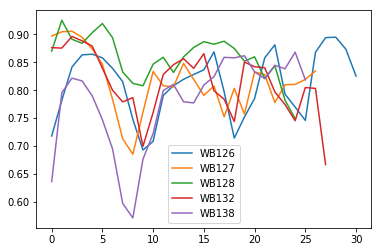

In [89]:
#方法2
pd.options.display.precision = 4

df2=pd.DataFrame([dice_dic_b[k][2:-2] for k in list(dice_dic_b.keys())],index=list(dice_dic_b.keys())).T

for i in range(len(WBkeys)):
    print(WBkeys[i],"{:.3f}±{:.3f}".format(df2.mean()[i],df2.std()[i]))
    
df2.plot()
df2

In [ ]:
#2回ラプラシアン
WB126 0.825±0.079
WB127 0.827±0.078
WB128 0.794±0.071
WB132 0.821±0.079
WB138 0.838±0.033

In [ ]:
#2回ラプラシアン(6<i<15)
WB126 0.837±0.056
WB127 0.849±0.050
WB128 0.857±0.040
WB132 0.841±0.060
WB138 0.827±0.049

WB126 0.839±0.067
WB127 0.847±0.055
WB128 0.850±0.042
WB132 0.841±0.071
WB138 0.843±0.030


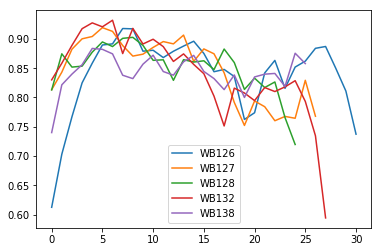

WB126   WB127   WB128   WB132   WB138
0   0.6125  0.8133  0.8128  0.8300  0.7401
1   0.7031  0.8431  0.8745  0.8584  0.8216
2   0.7671  0.8824  0.8518  0.8889  0.8399
3   0.8249  0.9001  0.8535  0.9174  0.8559
4   0.8585  0.9041  0.8773  0.9273  0.8837
5   0.8895  0.9192  0.8947  0.9206  0.8821
6   0.8915  0.9128  0.8869  0.9318  0.8744
7   0.9177  0.8886  0.9009  0.8749  0.8379
8   0.9171  0.8706  0.9026  0.9179  0.8322
9   0.8790  0.8739  0.8889  0.8913  0.8568
10  0.8806  0.8854  0.8634  0.8994  0.8721
11  0.8681  0.8954  0.8643  0.8868  0.8442
12  0.8789  0.8915  0.8292  0.8615  0.8380
13  0.8877  0.9064  0.8645  0.8744  0.8609
14  0.8960  0.8615  0.8604  0.8564  0.8718
15  0.8751  0.8829  0.8626  0.8406  0.8444
16  0.8439  0.8745  0.8476  0.8023  0.8323
17  0.8478  0.8421  0.8827  0.7513  0.8134
18  0.8357  0.7915  0.8596  0.8159  0.8384
19  0.7625  0.7522  0.8137  0.8076  0.8000
20  0.7739  0.7940  0.8330  0.7946  0.8350
21  0.8419  0.7842  0.8169  0.8169  0.8398
22  0.8633  0.7603  0.8264  0.8101  0.8410
23  0.8156  0.7676  0.7657  0.8180  0.8189
24  0.8519  0.7645  0.7197  0.8286  0.8755
25  0.8620  0.8293     NaN  0.7932  0.8578
26  0.8839  0.7680     NaN  0.7346     NaN
27  0.8870     NaN     NaN  0.5944     NaN
28  0.8499     NaN     NaN     NaN     NaN
29  0.8109     NaN     NaN     NaN     NaN
30  0.7373     NaN     NaN     NaN     NaN

In [90]:
#方法3
pd.options.display.precision = 4

df3=pd.DataFrame([dice_dic_c[k][2:-2] for k in list(dice_dic_c.keys())],index=list(dice_dic_c.keys())).T

for i in range(len(WBkeys)):
    print(WBkeys[i],"{:.3f}±{:.3f}".format(df3.mean()[i],df3.std()[i]))
    
df3.plot()
plt.show()
df3

In [96]:
import numpy as np
import os
from scipy import stats
import csv
import pprint
import pandas as pd
import matplotlib.pyplot as plt

#入力データ(CSV)

#グラフ保存場所
SAVEDIR=r"t_test\savefig"
os.makedirs(SAVEDIR,exist_ok="True")

ValueError: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 192 from PyObject

In [224]:
df = df2

# image 列をindexにする

df

WB126   WB127   WB128   WB132   WB138
0   0.7179  0.8972  0.8701  0.8765  0.6360
1   0.7818  0.9048  0.9255  0.8756  0.7955
2   0.8416  0.9059  0.8915  0.8965  0.8217
3   0.8635  0.8950  0.8842  0.8886  0.8167
4   0.8646  0.8741  0.9033  0.8792  0.7898
5   0.8580  0.8466  0.9197  0.8396  0.7472
6   0.8393  0.7840  0.8943  0.8000  0.6949
7   0.8154  0.7130  0.8327  0.7792  0.5971
8   0.7479  0.6852  0.8124  0.7867  0.5710
9   0.6928  0.7606  0.8080  0.6995  0.6764
10  0.7084  0.8337  0.8468  0.7601  0.7223
11  0.7907  0.8081  0.8591  0.8282  0.7995
12  0.8082  0.8059  0.8319  0.8457  0.8105
13  0.8196  0.8481  0.8597  0.8565  0.7793
14  0.8283  0.8193  0.8767  0.8394  0.7773
15  0.8366  0.7909  0.8872  0.8655  0.8093
16  0.8689  0.8075  0.8825  0.7990  0.8245
17  0.7973  0.7523  0.8880  0.7839  0.8591
18  0.7142  0.8032  0.8748  0.7439  0.8581
19  0.7520  0.7574  0.8522  0.8506  0.8619
20  0.7852  0.8328  0.8599  0.8421  0.8330
21  0.8581  0.8281  0.8209  0.8403  0.8208
22  0.8815  0.7779  0.8437  0.7971  0.8448
23  0.7930  0.8098  0.7822  0.7743  0.8385
24  0.7699  0.8105  0.7490  0.7454  0.8683
25  0.7459  0.8194     NaN  0.8048  0.8187
26  0.8680  0.8344     NaN  0.8033     NaN
27  0.8943     NaN     NaN  0.6667     NaN
28  0.8952     NaN     NaN     NaN     NaN
29  0.8736     NaN     NaN     NaN     NaN
30  0.8255     NaN     NaN     NaN     NaN

In [189]:
#平均と標準偏差
metrics=df.columns
MEAN=df.mean()
SD=df.std()
for i in range(len(metrics)):
    print(metrics[i],"{:.4f}±{:.4f}".format(MEAN[i],SD[i]))

WB126 0.8109±0.0580
WB127 0.8150±0.0544
WB128 0.8582±0.0418
WB132 0.8131±0.0567
WB138 0.7797±0.0820


In [212]:
print(A)

[0.717948717948718, 0.8971684053651267, 0.8700787401574803, 0.8764568764568764, 0.6360294117647058, 0.7818499127399651, 0.9048178613396005, 0.9255474452554745, 0.875605815831987, 0.795483061480552, 0.8415584415584415, 0.9059165858389913, 0.8914819136522754, 0.8964613368283093, 0.8216748768472907, 0.8634538152610441, 0.8950086058519794, 0.8842105263157894, 0.8886486486486487, 0.8167092924126172, 0.8646288209606987, 0.8741092636579573, 0.9032800672834315, 0.879162702188392, 0.7898089171974523, 0.8580441640378549, 0.8465530022238695, 0.9196969696969697, 0.839572192513369, 0.7471526195899773, 0.8393250183418929, 0.7840236686390533, 0.8943206326383897, 0.8, 0.6948640483383686, 0.8153846153846154, 0.7130044843049327, 0.8327402135231317, 0.7791519434628975, 0.597061098221191, 0.7478991596638656, 0.6851716581446311, 0.812373907195696, 0.7867219917012448, 0.5709728867623605, 0.6927921623512946, 0.7606420097697139, 0.8079896907216495, 0.6995433789954338, 0.676402767102229, 0.7084265473527218, 0.

In [91]:
A=np.array(df2.fillna(0)).reshape(-1)
A=np.array([a for a in A if a != 0])
B=np.array(df3.fillna(0)).reshape(-1)
B=np.array([b for b in B if b != 0])

In [92]:
print("A:",A.mean(),"±",A.std())
print("B:",B.mean(),"±",B.std())

A: 0.8148830917891047 ± 0.06363767352851611
B: 0.8436553006095259 ± 0.05516697193531994


In [95]:
#T_test

v,p=stats.ttest_rel(A, B)
if p<0.001:
    p_v="p<0.001"
elif p<0.01:
    p_v="p<0.01"
elif p<0.05:
    p_v="p<0.05"
else:
    p_v="p>0.05"
print("p_value(morph):",p,p_v)



textsize=14
#RMSE
fig=plt.figure(figsize=(6,8))
for i in range(len(df.index)):
    X,Y=[1,2],[A[i],B[i]]
    X_values=["rrobin","morph"]
    plt.scatter(X,Y,color=(0,0,0),marker="x")
    plt.plot(X,Y,color=(0,0,0), linewidth = 1.0)
plt.xlim(0.5,2.5)
y_lim=[0.8,1.02]
plt.ylim(y_lim)
plt.tick_params(labelsize=textsize) 
plt.xticks(X,X_values, fontsize=textsize)
y_ticks=np.arange(y_lim[0],y_lim[1],0.02)
plt.yticks(y_ticks)
#plt.title("MSE:SRCNN_vs_2.5D-SRCNN")

#p_value_bar:p値のついたバーを追加
bx1,bx2=1,2
by,bh=max([np.max(A),np.max(B)])+0.3*10**(-2),0.15*10**(-2)
#bar=[[bx1,by-bh],[bx1,by],[bx2,by],[bx2,by-bh]]
bar_x=bx1,bx1,bx2,bx2
bar_y=by-bh,by,by,by-bh
plt.plot(bar_x,bar_y,color=(0,0,0))
plt.text((bx1+bx2)/2-0.2,by+0.002,p_v, fontsize=textsize)

plt.xlabel("model", fontsize=textsize)
plt.ylabel("SSIM", fontsize=textsize)

#savefig
plt.savefig(os.path.join(SAVEDIR,"SSIM_2D-SRCNN_vs_2.5D-SRCNN_yokohama.png"), dpi=200, bbox_inches="tight", pad_inches=0.1)

NameError: name 'stats' is not defined

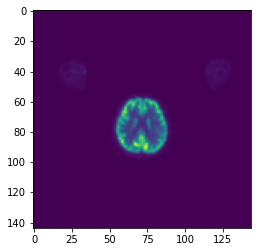

(0.0, 15.0)

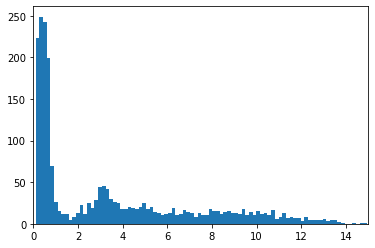

In [126]:
img=imgsPT[10]
plt.imshow(img)
plt.show()
data=img.reshape(-1)
data=data[np.where(data>0.1)]
plt.hist(data,bins=100)
plt.xlim(0,15)


WB126 0.811±0.058
WB127 0.815±0.054
WB128 0.858±0.042
WB132 0.813±0.057
WB138 0.780±0.082


WB126   WB127   WB128   WB132   WB138
0   0.7179  0.8972  0.8701  0.8765  0.6360
1   0.7818  0.9048  0.9255  0.8756  0.7955
2   0.8416  0.9059  0.8915  0.8965  0.8217
3   0.8635  0.8950  0.8842  0.8886  0.8167
4   0.8646  0.8741  0.9033  0.8792  0.7898
5   0.8580  0.8466  0.9197  0.8396  0.7472
6   0.8393  0.7840  0.8943  0.8000  0.6949
7   0.8154  0.7130  0.8327  0.7792  0.5971
8   0.7479  0.6852  0.8124  0.7867  0.5710
9   0.6928  0.7606  0.8080  0.6995  0.6764
10  0.7084  0.8337  0.8468  0.7601  0.7223
11  0.7907  0.8081  0.8591  0.8282  0.7995
12  0.8082  0.8059  0.8319  0.8457  0.8105
13  0.8196  0.8481  0.8597  0.8565  0.7793
14  0.8283  0.8193  0.8767  0.8394  0.7773
15  0.8366  0.7909  0.8872  0.8655  0.8093
16  0.8689  0.8075  0.8825  0.7990  0.8245
17  0.7973  0.7523  0.8880  0.7839  0.8591
18  0.7142  0.8032  0.8748  0.7439  0.8581
19  0.7520  0.7574  0.8522  0.8506  0.8619
20  0.7852  0.8328  0.8599  0.8421  0.8330
21  0.8581  0.8281  0.8209  0.8403  0.8208
22  0.8815  0.7779  0.8437  0.7971  0.8448
23  0.7930  0.8098  0.7822  0.7743  0.8385
24  0.7699  0.8105  0.7490  0.7454  0.8683
25  0.7459  0.8194     NaN  0.8048  0.8187
26  0.8680  0.8344     NaN  0.8033     NaN
27  0.8943     NaN     NaN  0.6667     NaN
28  0.8952     NaN     NaN     NaN     NaN
29  0.8736     NaN     NaN     NaN     NaN
30  0.8255     NaN     NaN     NaN     NaN

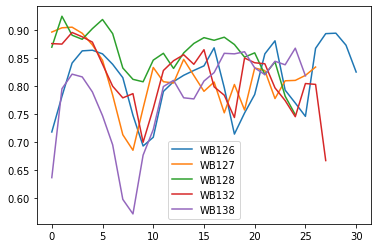

WB126 0.837±0.056
WB127 0.849±0.050
WB128 0.857±0.040
WB132 0.841±0.060
WB138 0.827±0.049


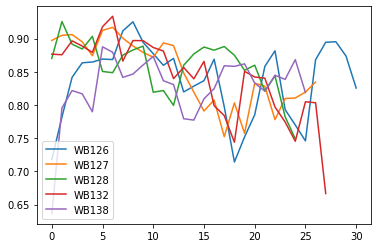

WB126   WB127   WB128   WB132   WB138
0   0.7179  0.8972  0.8701  0.8765  0.6360
1   0.7818  0.9048  0.9255  0.8756  0.7955
2   0.8416  0.9059  0.8915  0.8965  0.8217
3   0.8635  0.8950  0.8842  0.8886  0.8167
4   0.8646  0.8741  0.9033  0.8792  0.7898
5   0.8691  0.9123  0.8504  0.9178  0.8875
6   0.8684  0.9168  0.8486  0.9335  0.8793
7   0.9115  0.9005  0.8749  0.8660  0.8415
8   0.9252  0.8889  0.8828  0.8969  0.8465
9   0.8942  0.8791  0.8885  0.8968  0.8602
10  0.8772  0.8719  0.8192  0.8865  0.8729
11  0.8597  0.8934  0.8217  0.8812  0.8365
12  0.8701  0.8892  0.7994  0.8397  0.8307
13  0.8196  0.8481  0.8597  0.8565  0.7793
14  0.8283  0.8193  0.8767  0.8394  0.7773
15  0.8366  0.7909  0.8872  0.8655  0.8093
16  0.8689  0.8075  0.8825  0.7990  0.8245
17  0.7973  0.7523  0.8880  0.7839  0.8591
18  0.7142  0.8032  0.8748  0.7439  0.8581
19  0.7520  0.7574  0.8522  0.8506  0.8619
20  0.7852  0.8328  0.8599  0.8421  0.8330
21  0.8581  0.8281  0.8209  0.8403  0.8208
22  0.8815  0.7779  0.8437  0.7971  0.8448
23  0.7930  0.8098  0.7822  0.7743  0.8385
24  0.7699  0.8105  0.7490  0.7454  0.8683
25  0.7459  0.8194     NaN  0.8048  0.8187
26  0.8680  0.8344     NaN  0.8033     NaN
27  0.8943     NaN     NaN  0.6667     NaN
28  0.8952     NaN     NaN     NaN     NaN
29  0.8736     NaN     NaN     NaN     NaN
30  0.8255     NaN     NaN     NaN     NaN

WB126


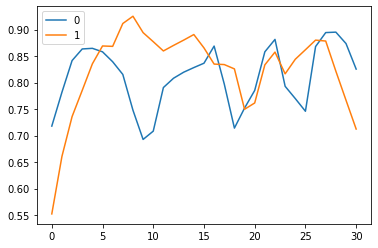

WB127


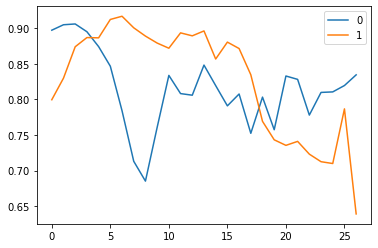

WB128


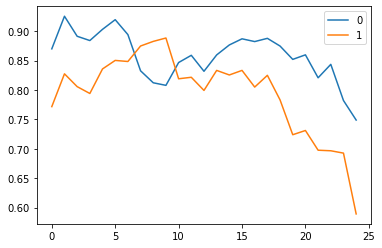

WB132


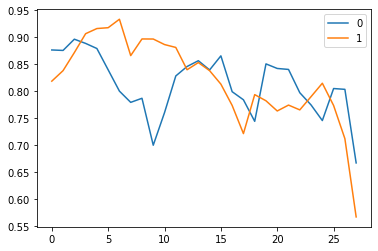

WB138


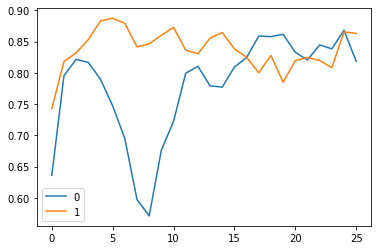

In [129]:
#方法2と方法3を比較
# fig=plt.figure(figsize=(15,3))

for i,k in enumerate(WBkeys):
    print(k)
#     ax=fig.add_subplot(1,len(WBkeys),i+1)

    df23=pd.DataFrame([dice_dic_b[k][2:-2],dice_dic_c[k][2:-2]  ]).T
    df23.plot()
    plt.show()
    df23

WB126
WB127
WB128
WB132
WB138


dice_lap1  dice_lap2    ret1    ret2  ret1-ret2
0      0.6082     0.4385  5.8638  2.7085     3.1553
1      0.7494     0.6310  5.9676  2.7408     3.2267
2      0.6360     0.7430  7.6920  3.4367     4.2552
3      0.7955     0.8182  6.7561  2.9563     3.7998
4      0.8217     0.8321  6.1485  2.7143     3.4343
5      0.8167     0.8533  5.9191  2.6657     3.2534
6      0.7898     0.8834  6.2709  2.7163     3.5546
7      0.7472     0.8875  6.7631  2.9148     3.8483
8      0.6949     0.8793  7.2594  3.0720     4.1874
9      0.5971     0.8415  7.3680  3.1474     4.2206
10     0.5710     0.8465  6.8976  2.9968     3.9008
11     0.6764     0.8602  6.1968  2.6462     3.5506
12     0.7223     0.8729  6.2529  2.5980     3.6549
13     0.7995     0.8365  6.1903  2.4970     3.6933
14     0.8105     0.8307  6.2566  2.5504     3.7062
15     0.7793     0.8557  6.6995  2.7048     3.9946
16     0.7773     0.8647  6.6847  2.7251     3.9596
17     0.8093     0.8385  5.8721  2.4384     3.4336
18     0.8245     0.8251  5.6857  2.4053     3.2804
19     0.8591     0.8002  5.3752  2.3382     3.0371
20     0.8581     0.8280  5.9728  2.6139     3.3589
21     0.8619     0.7849  5.2031  2.3643     2.8388
22     0.8330     0.8197  5.9334  2.6517     3.2817
23     0.8208     0.8246  5.3163  2.3937     2.9226
24     0.8448     0.8198  5.2529  2.3784     2.8746
25     0.8385     0.8085  5.1898  2.3389     2.8509
26     0.8683     0.8658  5.4195  2.5449     2.8746
27     0.8187     0.8632  5.9830  2.8258     3.1572
28     0.7742     0.7477  4.9773  2.3420     2.6353
29     0.4494     0.5274  4.1714  1.8388     2.3326

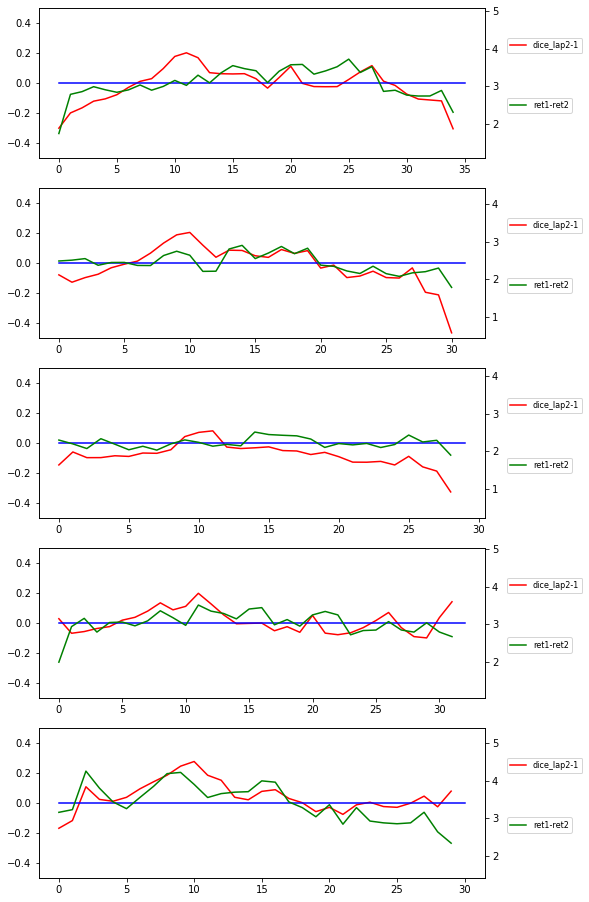

In [246]:
fig=plt.figure(figsize=(8,16))
for i,k in enumerate(WBkeys):
    print(k)
    ax1=fig.add_subplot(len(WBkeys),1,i+1)
    ax2=ax1.twinx()

    df23=pd.DataFrame([np.array(dice_dic_b[k]),np.array(dice_dic_c[k]),ret1_dic[k],ret2_dic[k],np.array(ret1_dic[k])-np.array(ret2_dic[k])  ],index=["dice_lap1","dice_lap2","ret1","ret2","ret1-ret2"]).T

#     ax1.plot(df23["dice_lap1"],label="dice_lap1",c="b")
#     ax1.plot(df23["dice_lap2"],label="dice_lap2",c="r")
    ax1.plot(df23["dice_lap2"]-df23["dice_lap1"],label="dice_lap2-1",c="r")
#     ax2.plot(df23["ret1"],label="ret1")
#     ax2.plot(df23["ret2"],label="ret2")
    ax2.plot(df23["ret1-ret2"],label="ret1-ret2",c="g")
    ax1.plot([0,len(df23["dice_lap2"])],[0,0],c="b")
    ax1.set_ylim(-0.5,0.5)
    a=df23["ret1-ret2"]
    amean=a.mean()
    ax2.set_ylim(a.mean()-2,a.mean()+2)
    ax1.legend(bbox_to_anchor=(1.05, 0.8), loc='upper left', borderaxespad=0, fontsize=8)
    ax2.legend(bbox_to_anchor=(1.05, 0.3), loc='lower left', borderaxespad=0, fontsize=8)

df23

In [ ]:
fig=plt.figure(figsize=(8,16))
for i,k in enumerate(WBkeys):
    print(k)
    ax1=fig.add_subplot(len(WBkeys),1,i+1)
    ax2=ax1.twinx()

    df23=pd.DataFrame([np.array(dice_dic_b[k]),np.array(dice_dic_c[k]),ret1_dic[k],ret2_dic[k],np.array(ret1_dic[k])-np.array(ret2_dic[k])  ],index=["dice_lap1","dice_lap2","ret1","ret2","ret1-ret2"]).T


    ax1.plot(df23["dice_lap2"]-df23["dice_lap1"],label="dice_lap2-1",c="r")

    df23["ret1-ret2"]


#方法1
WB126 0.841±0.064
WB127 0.855±0.042
WB128 0.861±0.038
WB132 0.842±0.072
WB138 0.847±0.031

#方法2
WB126 0.811±0.058
WB127 0.815±0.054
WB128 0.858±0.042
WB132 0.813±0.057
WB138 0.780±0.082

#方法3
WB126 0.847±0.047
WB127 0.843±0.044
WB128 0.860±0.038
WB132 0.846±0.051
WB138 0.834±0.049

#方法4
WB126 0.825±0.079
WB127 0.827±0.078
WB128 0.794±0.071
WB132 0.821±0.079
WB138 0.838±0.033

In [16]:
pd.options.display.precision = 4
# df1=pd.DataFrame([dice_dic_a[k][2:-2] for k in list(dice_dic_a.keys())],index=list(dice_dic_a.keys())).T
df1

WB126   WB127   WB128   WB132   WB138
0   0.6212  0.8379  0.8449  0.8323  0.7352
1   0.7087  0.8643  0.8997  0.8622  0.8199
2   0.7790  0.9055  0.8733  0.8897  0.8406
3   0.8411  0.9114  0.8783  0.9183  0.8569
4   0.8654  0.9147  0.8933  0.9302  0.8867
5   0.8940  0.9066  0.9147  0.9193  0.8845
6   0.8960  0.8912  0.9002  0.9330  0.8855
7   0.9160  0.8484  0.8980  0.8760  0.8614
8   0.9158  0.8086  0.8739  0.9064  0.8458
9   0.8772  0.8410  0.8510  0.8927  0.8526
10  0.8782  0.8758  0.8586  0.8963  0.8717
11  0.8674  0.8885  0.8647  0.8853  0.8494
12  0.8790  0.8829  0.8391  0.8655  0.8444
13  0.8880  0.9134  0.8738  0.8777  0.8617
14  0.8961  0.8593  0.8786  0.8558  0.8739
15  0.8757  0.8880  0.8683  0.8444  0.8481
16  0.8472  0.8860  0.8632  0.8072  0.8355
17  0.8524  0.8471  0.8933  0.7595  0.8197
18  0.8339  0.8062  0.8721  0.8159  0.8411
19  0.7593  0.7561  0.8353  0.8047  0.8046
20  0.7761  0.8419  0.8524  0.7946  0.8386
21  0.8413  0.8313  0.8273  0.8294  0.8443
22  0.8604  0.7872  0.8435  0.8205  0.8489
23  0.8152  0.8213  0.7819  0.8127  0.8341
24  0.8482  0.7985  0.7420  0.8271  0.8745
25  0.8563  0.8380     NaN  0.7932  0.8578
26  0.8835  0.8303     NaN  0.7346     NaN
27  0.8851     NaN     NaN  0.5836     NaN
28  0.8598     NaN     NaN     NaN     NaN
29  0.8182     NaN     NaN     NaN     NaN
30  0.7500     NaN     NaN     NaN     NaN

In [ ]:
#方法1でしきい値ごとのdice係数を算出

#検証するしきい値
num_lis=np.arange(2.0,4.1,0.1)

for num_th in num_lis:
    brain1 = []
    brain2 = []
    fig = plt.figure()
    
    #WB一覧
    WB_list=os.listdir(dir_path_PT)

    for WB in range(WB_list):
        file_list=os.listdir(os.path.join(dir_path_PT,WB))
        for i in range(len(file_list))
        img_file_name = file_list[i]
        path=os.path.join(dir_path_PT,WB,img_file)
        nib_path = nib.load(path)
        img_data = nib_path.get_fdata().T[::-1]
        ax1 = fig.add_subplot(row,col,file_number+1)
        img2 =img_data[20]
        ret,thresh1 = cv2.threshold(img2,2,255,cv2.THRESH_BINARY)
        kara=np.zeros_like(thresh1)
        plt.title(file_number)
        ax1.imshow(img2,cmap="gray_r")
        ax1.imshow(thresh1,cmap=RdWh,alpha=0.5)
        ax1.axes.xaxis.set_visible(False)
        ax1.axes.yaxis.set_visible(False)

        brain1_lis = []
        brain2_lis = []
        switch1=0
        switch2=1
        for i, img in enumerate(img_data):
            brain1_lis.append(img)
            ret,thresh1=cv2.threshold(img,num_th,255,cv2.THRESH_BINARY)
            if 3<img.max():
                switch1=1
            if 3<img.max() and switch1==1 and switch2==1:
                brain2_lis.append(thresh1)
            else:
                brain2_lis.append(kara)
                if switch1==1 and i>10:
                    switch2=0
        arr_brain1 = np.array(brain1_lis)
        arr_brain2 = np.array(brain2_lis)
        brain1.append(arr_brain1)
        brain2.append(arr_brain2)

In [19]:
thSUV=3
# th=thSUV/imga.max()*255
ret,thresh_a=cv2.threshold(imga,thSUV,1,cv2.THRESH_BINARY)
ret,thresh_b=cv2.threshold(imgb,thSUV,1,cv2.THRESH_BINARY)
c_red=clearcmap(cm.Reds)
plt.imshow(thresh_a,cmap=c_red,vmax=1,vmin=0)
plt.show()
plt.imshow(thresh_b,cmap=c_red,vmax=1,vmin=0)
plt.show()

error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\thresh.cpp:1632: error: (-210:Unsupported format or combination of formats)  in function 'cv::threshold'


In [ ]:
#imgaとimgbのdice係数
d=Dice_Calculater(thresh_a,thresh_b)
print(d)

In [ ]:
#ROIの読み込み
ROI_path=r"C:\Users\k\seki_anno\anotation\WB127\0023.npy"
roi_img=np.load(ROI_path)
print(roi_img.max())
plt.imshow(roi_img,cmap=c_red,vmax=1,vmin=0)


In [ ]:
#imgaとROIのdice係数
d=Dice_Calculater(thresh_a,roi_img)
print(d)